In [1]:
import utils
from utils import *
import importlib
import numpy as np
import math
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
import time




In [218]:
def run_neural_network(X_train, y_train, X_test, y_test, subset_size=0.016):
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.016)
    #X_train, y_train, X_test, y_test = split_data(X_train, y_train, train_size=0.08)
    
    num_category = 10 

    y_train_oh = keras.utils.to_categorical(y_train, num_category)
    y_test_oh = keras.utils.to_categorical(y_test, num_category)

    model = keras.Sequential()
    print(X_train.shape)
    #model.add(Dense(32, input_dim=784))
    #model.add(Conv2D(32, [3, 3], activation='relu', input_shape=(X_train.shape[1],)))
    #model.add(Reshape((28, 28, 1), input_shape=(X_train.shape[1],)))
    #model.add(Conv2D(2, (2, 2), activation='relu', ))
    input_img = Input(shape=(784,))
    model.add(Dense(128, activation='relu')(input_img))
    model.add(Conv2D(4, (2, 2), activation='relu', input_shape=X_train.shape[1]))
    model.add(Conv2D(8, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Train and fit the model:
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train_oh, epochs=20, verbose=1, batch_size=32,  validation_split=.1)
    loss, accuracy  = model.evaluate(X_test, y_test_oh, verbose=False)
    print(history.history)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('VGG16 accuracy diabetes')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print('Test loss: ', loss)
    print('Test accuracy: ', accuracy)
    
    
def load_data(clean=False):
    data_directory = "data/"
    filename = "diabetes.csv"
    df = pd.read_csv(data_directory + filename)
    if clean:
        df = df[df['SkinThickness'] > 0]
        df = df[df['Insulin'] > 0]
    #plt.show()
    cols = list(df.columns.values)
    cols.remove('Outcome')
    X = (df[cols]).values
    y = df['Outcome'].values
    if clean:
        X = StandardScaler().fit_transform(X)
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=data_size-train_size)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=data_size-train_size)
    return(X_train, y_train, X_test, y_test)

def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10], exp_name='base'):

    times = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        start_time = time.time()

        cluster_labels = clusterer.fit_predict(X)
        end_time = time.time() - start_time
        times.append(end_time)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        title = "silhouette plot # clusters diabetes -- " + exp_name
        ax1.set_title(title)
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([]) 
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
        
        ax2.set_title("Cluster viz")
        ax2.set_xlabel("1st feature")
        ax2.set_ylabel("2nd feature")
        title = "silhouette kmeans diabetes -- " + exp_name
        plt.suptitle((title),fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    title = "k means fit time per # clusters diabetes -- " + exp_name
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    
def k_means_silhouette_iloc(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10], exp_name='base'):

    times = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        start_time = time.time()

        cluster_labels = clusterer.fit_predict(X)
        end_time = time.time() - start_time
        times.append(end_time)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        title = "silhouette plot # clusters diabetes -- " + exp_name
        ax1.set_title(title)
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([]) 
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
        
        ax2.set_title("Cluster viz")
        ax2.set_xlabel("1st feature")
        ax2.set_ylabel("2nd feature")
        title = "silhouette kmeans diabetes -- " + exp_name
        plt.suptitle((title),fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    title = "k means fit time per # clusters diabetes -- " + exp_name
    plt.title(title)
    plt.tight_layout()
    plt.show()

def k_means_experiment(X_train, X_test, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    X_train_new = kmeans.fit_transform(X_train)
    X_test_new = kmeans.transform(X_test)
    return X_train_new, X_test_new
    
def gmm_experiment(X_train, X_test, comps):
    gmm = GMM(random_state=13, n_components=comps)
    X_train_new = gmm.fit_transform(X_train)
    X_test_new = gmm.transform(X_test)
    return X_train_new, X_test_new
    
    
def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6], exp_name='base'):
    aics = []
    bics = []
    scores = []
    times=[]
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        start_time = time.time()
        gmm.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    title = "AIC/BIC elbow per n_clusters diabetes -- " + exp_name
    plt.title (title)
    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    title = "gmm fit time per # clusters diabetes -- " + exp_name
    plt.title (title)
    plt.title('gmm fit time per # clusters diabetes')
    plt.tight_layout()
    plt.show()



def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(X, y, vals_range=[1, 2, 3, 4, 5, 6, 7]):
    result_dfs = []
    times = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        start_time = time.time()
        components = pca.fit_transform(X)
        end_time = time.time() - start_time
        times.append(end_time)
        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)

        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
        plt.plot(vals_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
        return result_dfs

def pca_experiment(X_train, X_test, y_train, n_components, variance_thresh, visualize=True):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X_train)
    test_components = pca.transform(X_test)
    print(X_train.shape)
    print(components.shape)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y_train, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    if visualize:
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    cumsum = 0
    last_col_to_keep = 0
    for i in range(n_components):
        print(variance_ratio['var'][i])
        if cumsum < variance_thresh:
            print("yes")
            cumsum += variance_ratio['var'][i]
            last_col_to_keep = i
    print(components.shape)
    components_to_keep = components[:, :last_col_to_keep]
    test_components_to_keep = test_components[:, :last_col_to_keep]
    print(components_to_keep.shape)
    return(components_to_keep, test_components_to_keep)

def analyze_ICA(X, n_components, visualize=True):
    rec_err = []
    avg_kurts = []
    times = []
    best_kurt = -9999
    best_n_comp_val = 0
    comp_range = range(1, n_components)
    for i in comp_range:
        print(i)
        ica = FastICA(n_components=i)
        start_time = time.time()
        ica.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        rec_err.append(reconstructionError(ica,X))
        kurt = np.average(kurtosis(ica.components_))
        avg_kurts.append(kurt)
        if kurt > best_kurt:
            best_kurt = kurt
            best_n_comp_val = i
    if visualize:
        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,avg_kurts, 'bo', comp_range,avg_kurts,'k')
        plt.xlabel('# Components')
        plt.ylabel('Avg Kurtosis')
        plt.title('ICA Kurtosis for # Components') #NM
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,
                 rec_err,
                 'bo',
                 comp_range,
                 rec_err,
                 'k')
        plt.xlabel('# Components')
        plt.ylabel('rec err')
        plt.title('ICA err for # Components')
        plt.tight_layout()
        plt.show()
        
        plt.plot(comp_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
    return best_n_comp_val, best_kurt
  

def ica_experiment(X_train, X_test, y_train, y_test, n_comps, visualize=True):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X_train)
    #X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y_train, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    
    X_transformed_test = transformer.transform(X_test)
    #X_transformed.shape
    pdf_test = pd.DataFrame(data = X_transformed_test, columns = columns_na)
    pdy_test = pd.DataFrame(data=y_test, columns=['labels'])
    icaDf_test = pd.concat([pdf_test, pdy_test], axis = 1)
    
    if visualize:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_zlabel('ic 3', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['g', 'r']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , icaDf.loc[points_in_label, 'ic 3']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        #ax.set_ylim(-1, 1)
        ax.grid()
    icaDf = icaDf.drop(columns=['labels'])
    icaDf_test = icaDf_test.drop(columns=['labels'])

    return icaDf, icaDf_test




def run_SparseRandomProjection(X,title):

    dims = list(np.arange(2,(X.shape[1]-1),1))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in product(range(5),dims):
        print(i)
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'r-')
    ax1.set_xlabel('# components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='r')
    ax1.tick_params('y', colors='r')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'g-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='g')
    ax2.tick_params('y', colors='g')
    plt.grid(False)

    plt.title("diabetes # random components")
    fig.tight_layout()
    plt.show()

def RP_experiment(X_train, X_test, n_comps, visualize=True):
    rp = SparseRandomProjection(n_components=n_comps)
    X_train_new = rp.fit_transform(X_train)
    X_test_new = rp.transform(X_test)
    return(X_train_new, X_test_new)

def RFC_experiment_diab(X_train, X_test, y, columns, x_indices, threshold=0.8, visualize=True):
    print(X)
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y)
    zipped = zip(df.columns[:-1], rnd_clf.feature_importances_)
    for name, importance in zipped:
        print(name, "=", importance)
    zipped = list(zip(df.columns[:-1], rnd_clf.feature_importances_))
    print(zipped)
    res = sorted(zipped, key = lambda x: x[1], reverse=True)
    print(res)

    indices = np.argsort(rnd_clf.feature_importances_)
    print(indices)

    cumsum = 0
    useful_cols = []
    useful_indices = []
    i = 0
    while cumsum < threshold:
        cumsum += res[i][1]
        useful_cols.append(res[i][0])
        i+=1

    for column, idx in zip(df.columns[:-1], x_indices):
        if column in useful_cols:
            useful_indices.append(idx)
    print("hm ",useful_indices)
    #print(X_copy.shape)
    X_train_copy = X_train_copy[:, useful_indices]
    X_test_copy = X_test_copy[:, useful_indices]
    #print(X_copy.shape)
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [df.columns[:-1][i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    return(X_train_copy, X_test_copy)

def RFC_experiment(X_train, X_test, y, threshold=0.8, visualize=True):
    #print(X)
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y)
    indices = np.argsort(-(rnd_clf.feature_importances_))
    cumsum = 0
    useful_cols = []
    useful_indices = []
    i = 0
    while cumsum < threshold:
        print(rnd_clf.feature_importances_[indices[i]])
        cumsum += rnd_clf.feature_importances_[indices[i]]
        #print(cumsum)
        useful_indices.append(indices[i])
        i+=1

    #for column, idx in zip(df.columns[:-1], x_indices):
    #    if column in useful_cols:
    #        useful_indices.append(idx)
    #print("hm ",useful_indices)
    print(X_train_copy.shape)
    X_train_copy = X_train_copy[:, useful_indices]
    X_test_copy = X_test_copy[:, useful_indices]
    print(X_train_copy.shape)
    print("X shape")
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        #plt.yticks(range(len(indices)), [i for i in rnd_clf.feature_importances_[indices]])
        plt.xlabel('Relative Importance')
        plt.xlabel('Sorted attr by importancce')
        plt.show()
    return(X_train_copy, X_test_copy)



def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [62]:
X, y = load_data(clean=True)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.016)

In [63]:
print(X.shape)
print(y.shape)

(394, 8)
(394,)


In [64]:
X_train, y_train, X_test, y_test =split_data(X, y, data_size=1.0, 
                                             train_size=0.9, strat=False)

In [65]:
print(X_train.shape)
print(y_train.shape)

(354, 8)
(354,)


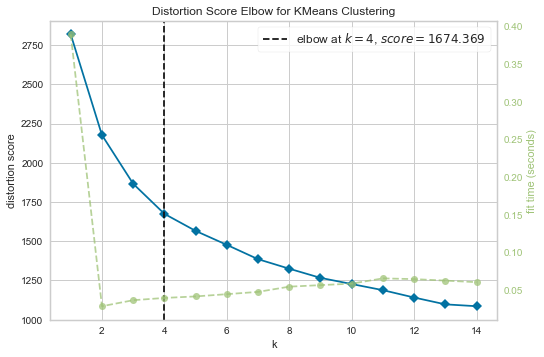

In [66]:
range_tpl = tuple(range(1, 15))
k_means_elbow_viz(X_train, k_range=range_tpl)

For n_clusters = 2 The average silhouette_score is : 0.2396392567469373
For n_clusters = 3 The average silhouette_score is : 0.20336629000221093
For n_clusters = 4 The average silhouette_score is : 0.1937202045666427
For n_clusters = 5 The average silhouette_score is : 0.15621719857362018
For n_clusters = 6 The average silhouette_score is : 0.15756847518650474
For n_clusters = 7 The average silhouette_score is : 0.1607737962990791
For n_clusters = 8 The average silhouette_score is : 0.1567063596407105
For n_clusters = 9 The average silhouette_score is : 0.13236861771117908
For n_clusters = 10 The average silhouette_score is : 0.15410114610859282


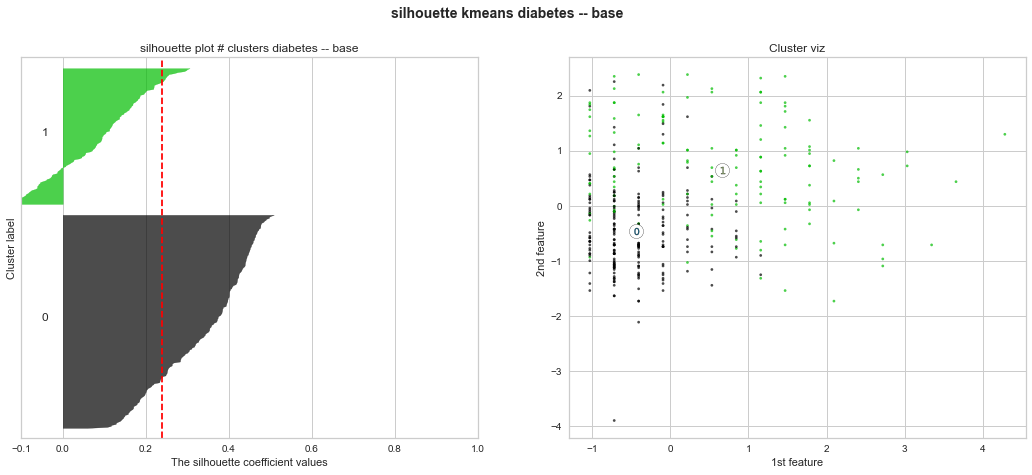

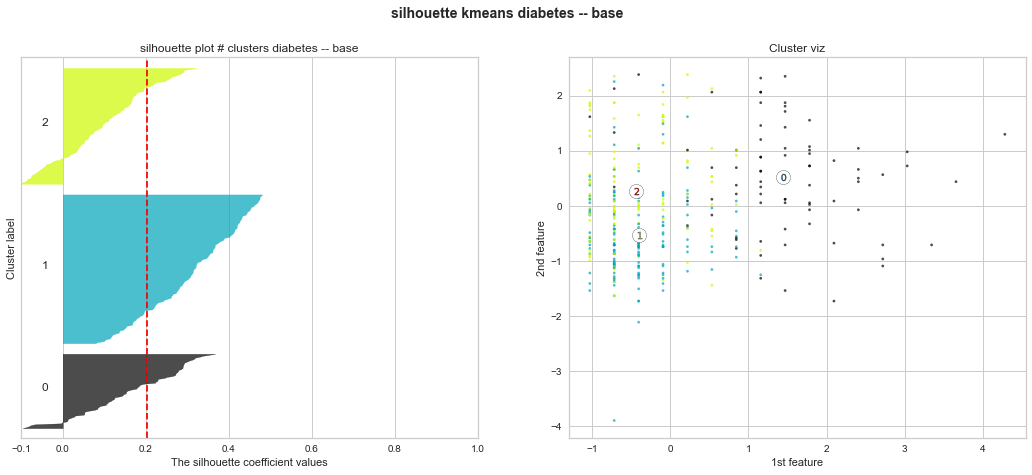

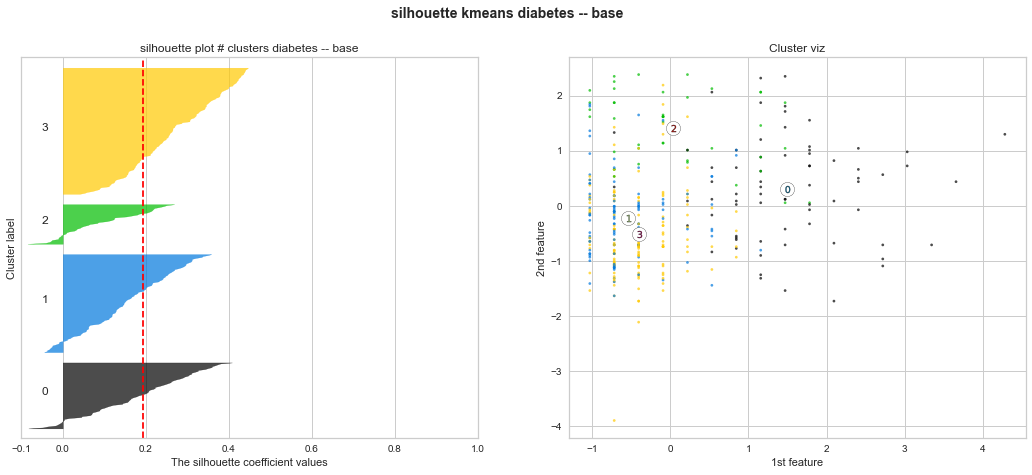

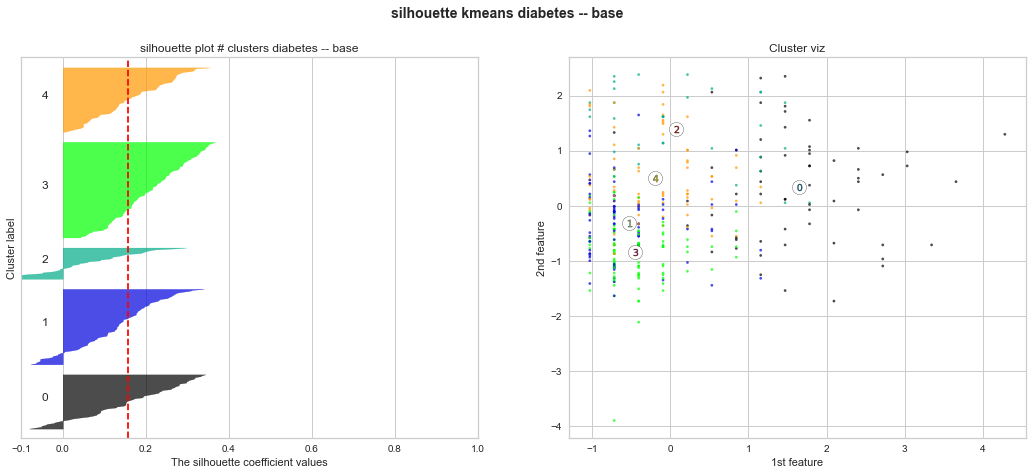

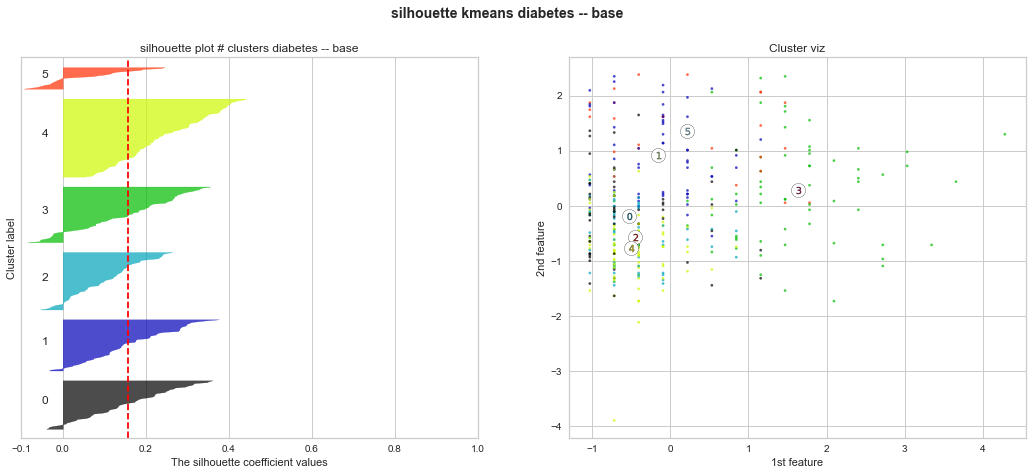

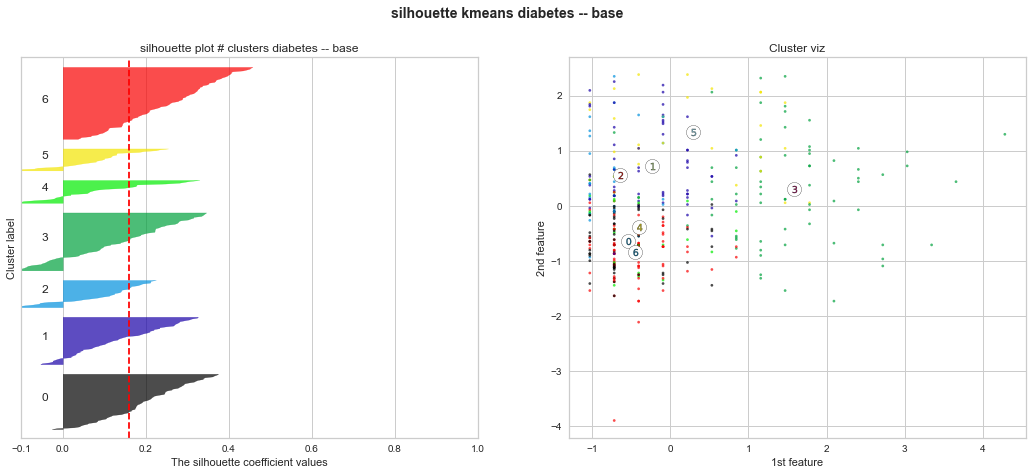

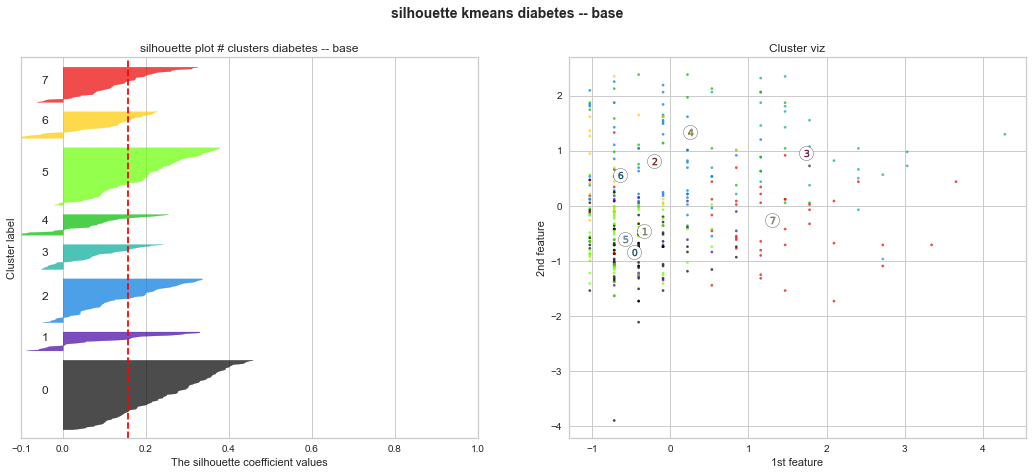

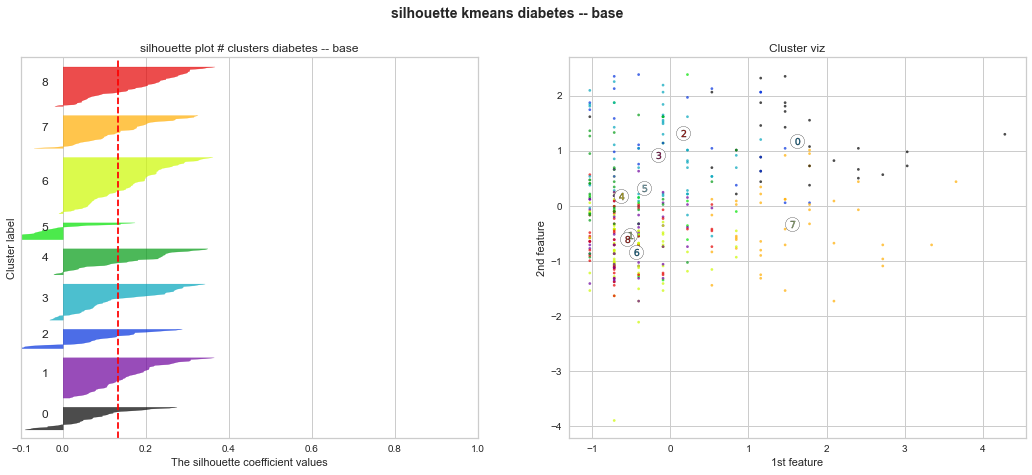

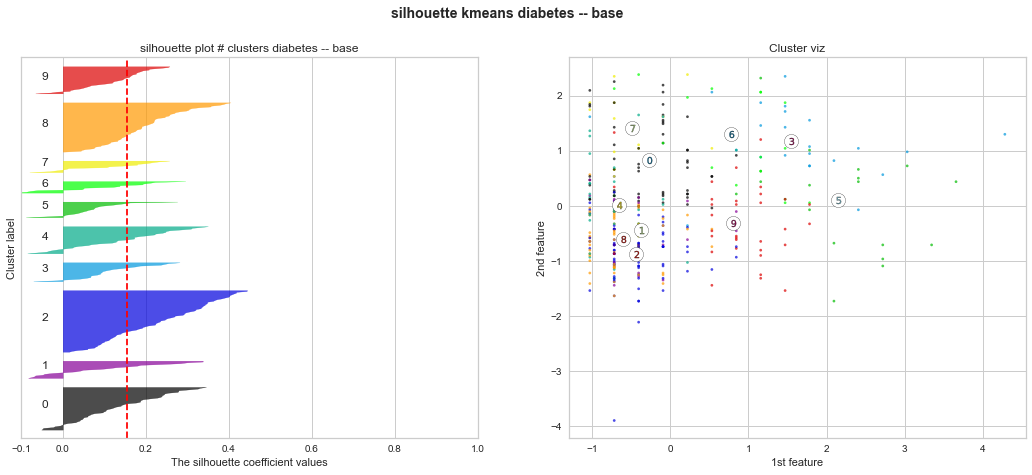

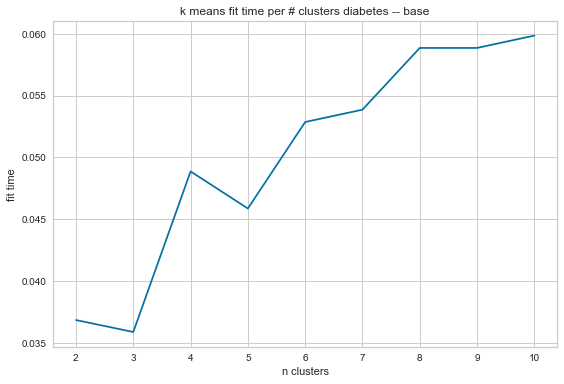

In [67]:
k_means_silhouette(X_train)

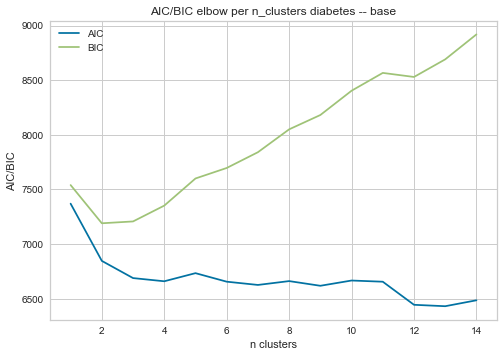

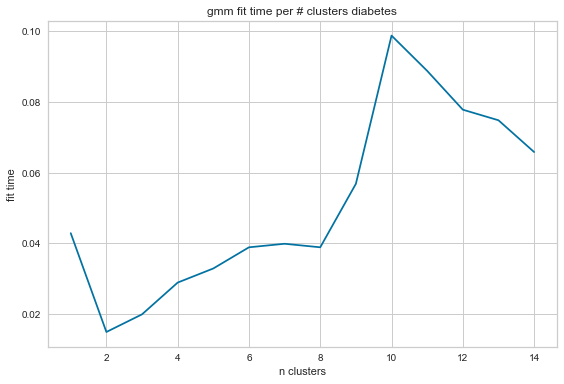

In [68]:
GMM_elbow(X_train, y_train, range_n_clusters=range(1, 15))

In [69]:
kmeans_X_train, kmeans_X_test = k_means_experiment(X_train, X_test, 6)
gmm_X_train, gmm_X_test = k_means_experiment(X_train, X_test, 6)


# PCA

(354, 8)
(354, 8)


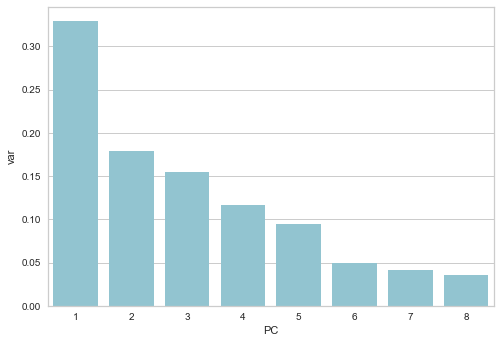

0.3292093023791925
yes
0.17873818703539684
yes
0.15475421866321218
yes
0.11645960789739719
yes
0.09415407984927494
yes
0.04918081362484549
yes
0.04132920500987432
yes
0.036174585540806575
(354, 8)
(354, 6)


<Figure size 576x396 with 0 Axes>

In [70]:
pca_X_train, pca_X_test = pca_experiment(X_train, X_test,  y_train, 8, 0.95)

In [71]:
print(pca_X_train.shape)
print(pca_X_test.shape)

(354, 6)
(40, 6)


# ICA

1
2
3
4
5
6
7


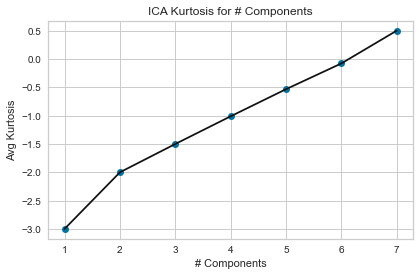

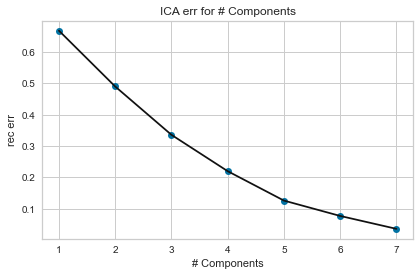

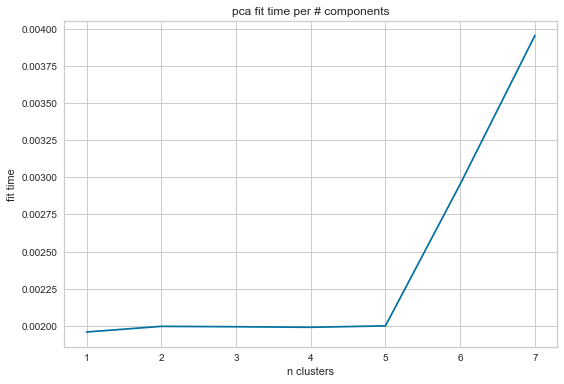

7


In [145]:
best_n_comp_val, best_kurt = analyze_ICA(X_train, 8)
print(best_n_comp_val)


         ic 1      ic 2      ic 3      ic 4      ic 5      ic 6      ic 7
0   -0.017891  0.040597  0.061217  0.072613  0.028540  0.002955 -0.018150
1   -0.021171  0.052274 -0.004244 -0.014130 -0.062652 -0.005199  0.076984
2    0.268765  0.036582 -0.010628 -0.071008 -0.065586 -0.003422 -0.024918
3   -0.023204  0.040194 -0.000869 -0.024914  0.017186  0.006529 -0.036220
4   -0.039476 -0.058766  0.006607  0.049872 -0.026555 -0.006931 -0.005691
..        ...       ...       ...       ...       ...       ...       ...
349  0.037996 -0.037627  0.033756  0.030707  0.058196 -0.023379 -0.013664
350  0.081211 -0.018975 -0.117839 -0.017427 -0.010198  0.073861  0.087876
351  0.028405 -0.029148 -0.056435  0.069415  0.030738  0.042672  0.005129
352 -0.004895 -0.031204 -0.074921 -0.061203  0.038189  0.045649  0.016136
353 -0.055413 -0.041945 -0.008108 -0.041893  0.002787 -0.011051 -0.038879

[354 rows x 7 columns]
        ic 1      ic 2      ic 3      ic 4      ic 5      ic 6      ic 7
0  -0.032482  0

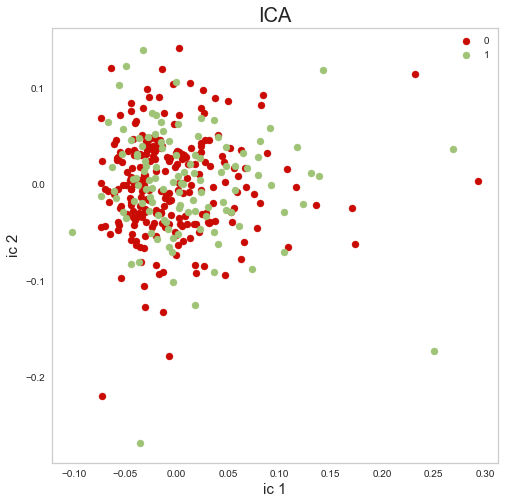

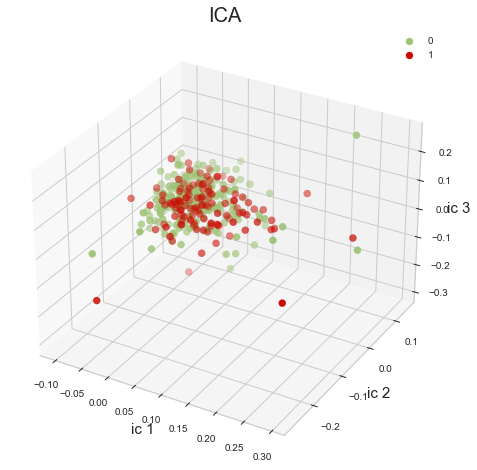

In [146]:
ica_X_train, ica_X_test = ica_experiment(X_train, X_test, y_train, y_test, best_n_comp_val)
print(ica_X_train)
print(ica_X_test)

# RP

0
0
0
0
0
0
1
1
1
1
1
1
2
2
2
2
2
2
3
3
3
3
3
3
4
4
4
4
4
4


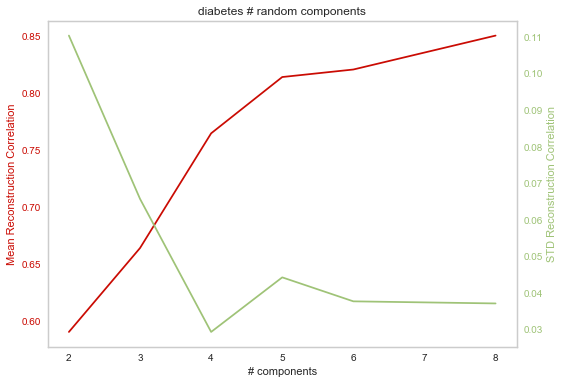

In [161]:
run_SparseRandomProjection(X_train,"base")
RP_X_train, RP_X_test = RP_experiment(X_train, X_test, 4)

# RFC

In [75]:
#data_directory = "data/"
#filename = "diabetes.csv"
#df = pd.read_csv(data_directory + filename)

[[-0.71338621 -1.06211441 -0.37375871 ... -0.67887456 -1.02533958
  -0.96354812]
 [-1.02534421  0.46865131 -2.46142734 ...  1.4041682   5.04016543
   0.21453709]
 [-0.08947019 -1.41291488 -1.65847787 ... -0.27615296 -0.79370078
  -0.47267928]
 ...
 [-0.4014282  -1.09400536 -1.01611829 ... -0.63721371  0.68764368
  -0.86537435]
 [ 2.09423587 -0.67942298  0.42919076 ... -0.01230088 -1.01390063
   3.15975012]
 [ 0.53444583 -0.04160393  0.10801097 ... -0.94272665 -0.80227999
  -0.07998421]]
Pregnancies = 0.07825396184575792
Glucose = 0.24631629950462455
BloodPressure = 0.07463309166448655
SkinThickness = 0.08178833304511478
Insulin = 0.15801924985897442
BMI = 0.11534600591474366
DiabetesPedigreeFunction = 0.1089969820259273
Age = 0.13664607614037078
[('Pregnancies', 0.07825396184575792), ('Glucose', 0.24631629950462455), ('BloodPressure', 0.07463309166448655), ('SkinThickness', 0.08178833304511478), ('Insulin', 0.15801924985897442), ('BMI', 0.11534600591474366), ('DiabetesPedigreeFunction'

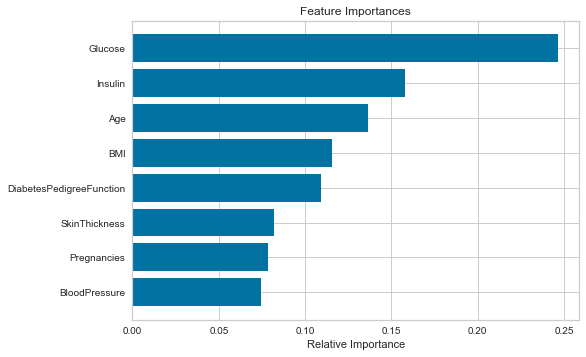

In [84]:
data_directory = "data/"
filename = "diabetes.csv"
df = pd.read_csv(data_directory + filename)
indices = range(0,len(df.columns[:-1]))
RFC_X_train, RFC_X_test = RFC_experiment_diab(X_train, X_test, y_train, df.columns[:-1], x_indices=indices)

In [85]:
print(pca_X_train.shape)
print(ica_X_train.shape)
print(RP_X_train.shape)
print(RFC_X_train.shape)

print(pca_X_test.shape)
print(ica_X_test.shape)
print(RP_X_test.shape)
print(RFC_X_test.shape)

(354, 6)
(354, 8)
(354, 5)
(354, 6)
(40, 6)
(354, 8)
(40, 5)
(40, 6)


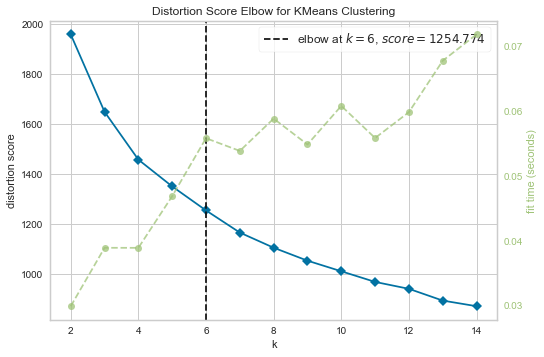

For n_clusters = 2 The average silhouette_score is : 0.24674214420165452
For n_clusters = 3 The average silhouette_score is : 0.22372692104663064
For n_clusters = 4 The average silhouette_score is : 0.21794539657336467
For n_clusters = 5 The average silhouette_score is : 0.18407933771781548
For n_clusters = 6 The average silhouette_score is : 0.18045248947376646
For n_clusters = 7 The average silhouette_score is : 0.18938341523523675
For n_clusters = 8 The average silhouette_score is : 0.17262024619364558
For n_clusters = 9 The average silhouette_score is : 0.1801630290013667
For n_clusters = 10 The average silhouette_score is : 0.16995280641771113


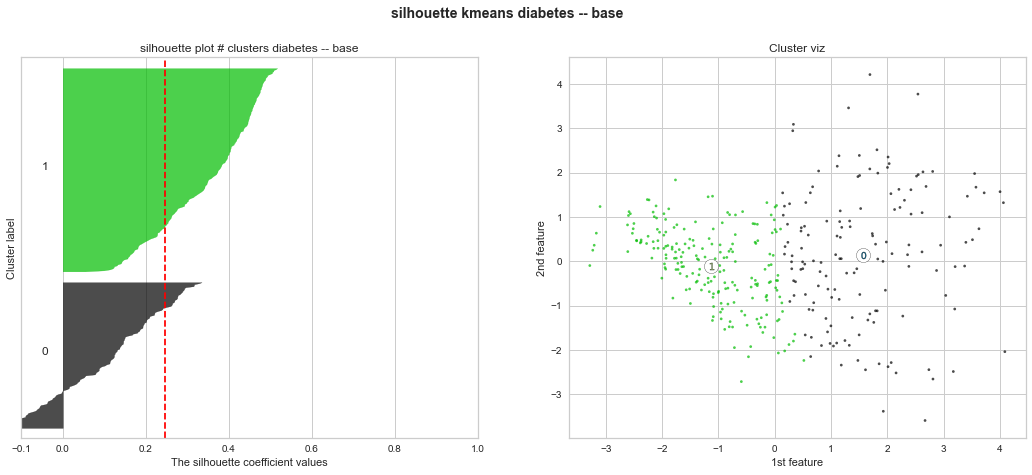

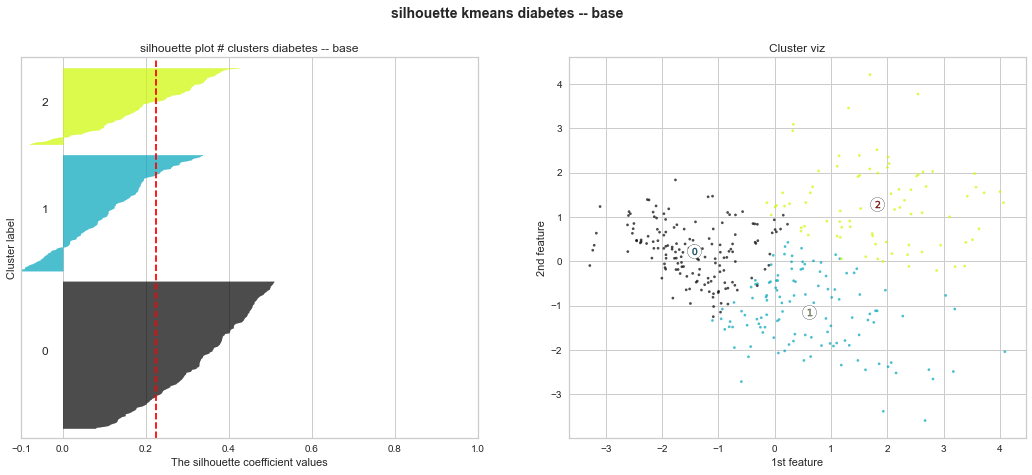

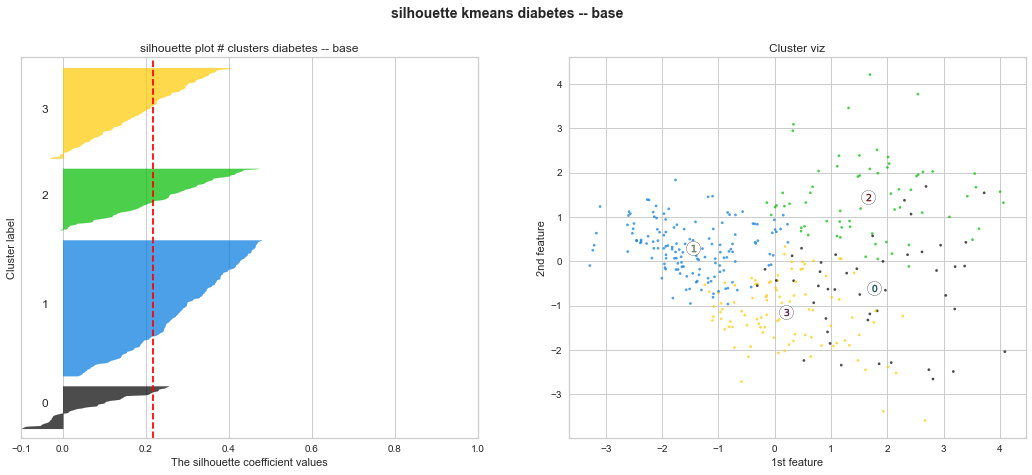

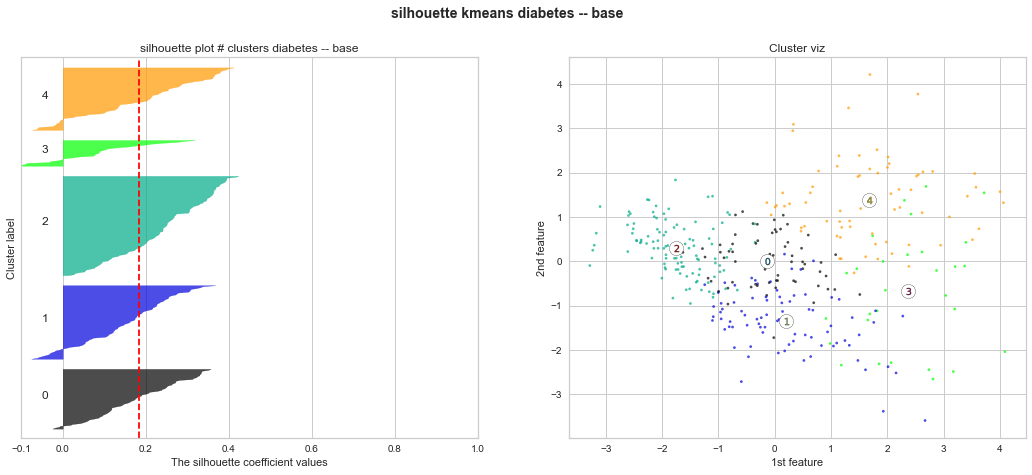

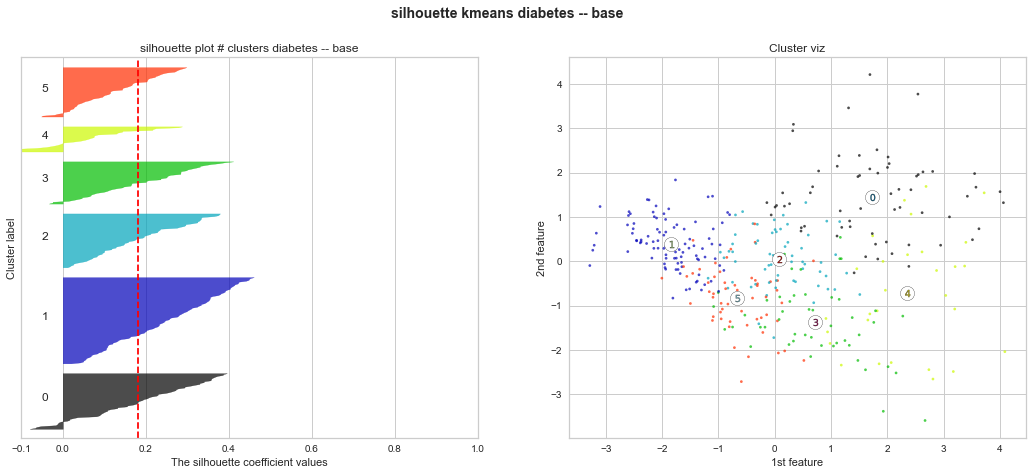

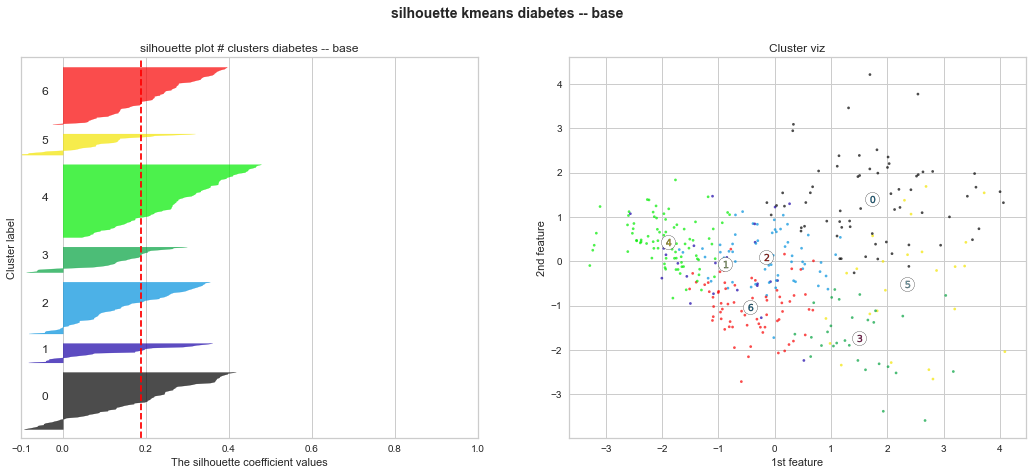

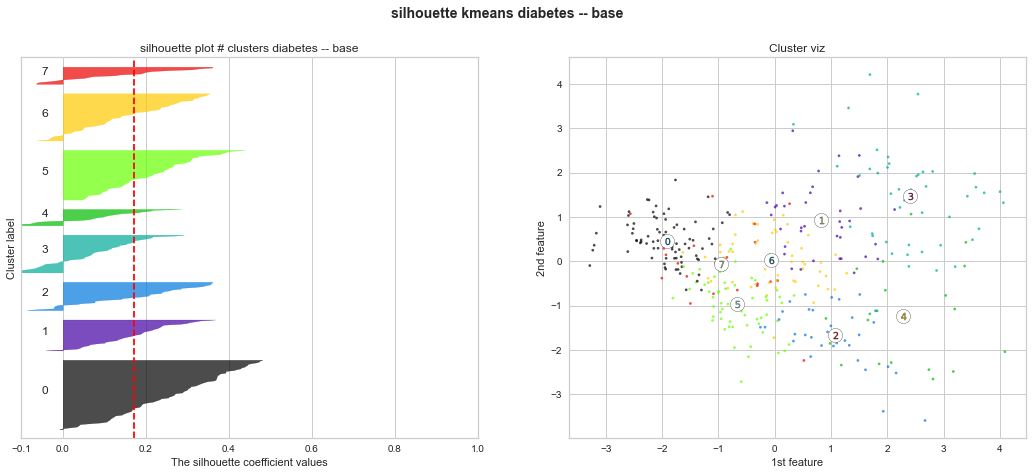

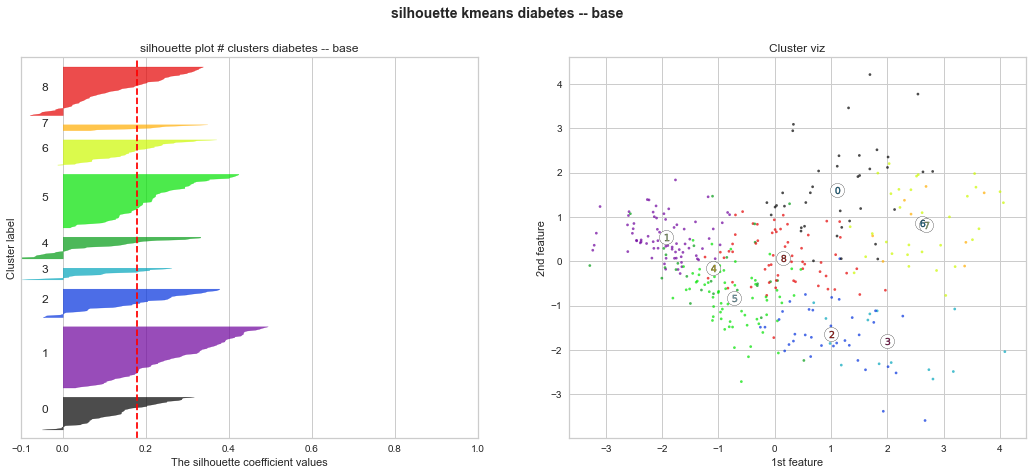

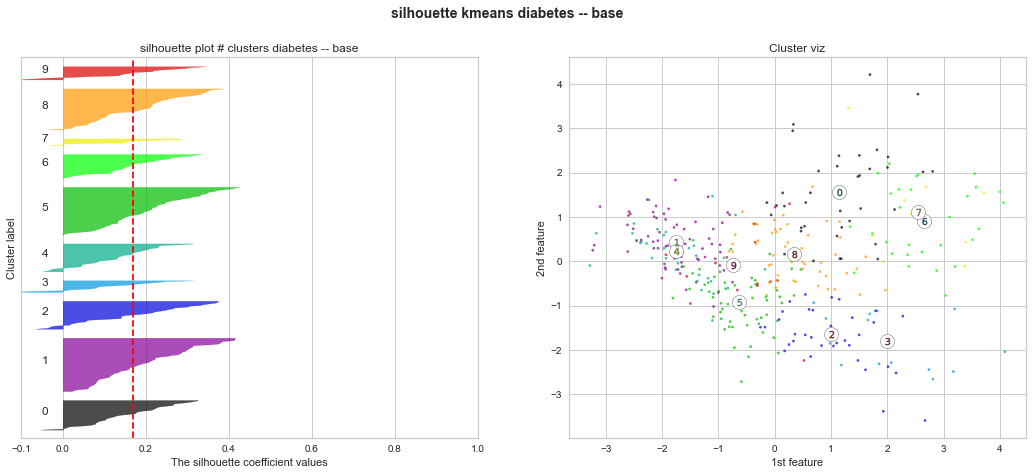

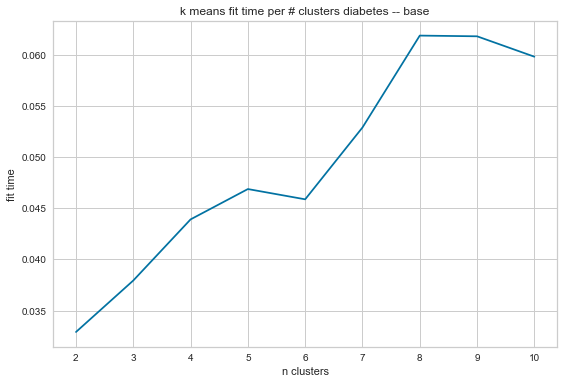

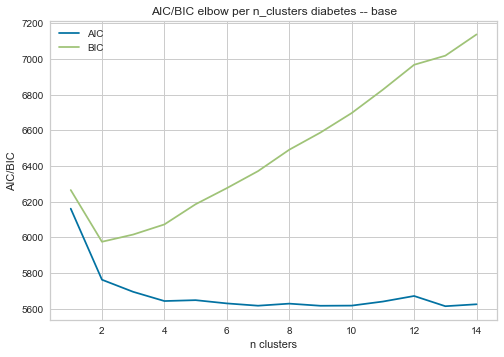

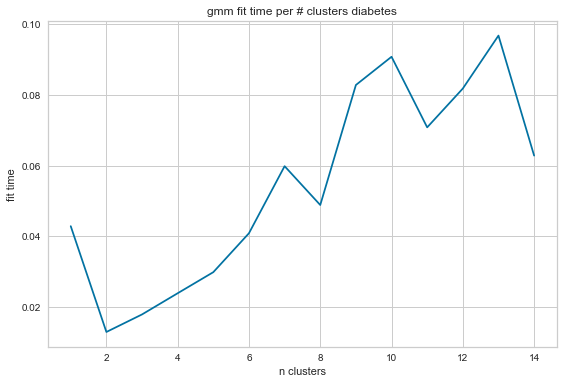

In [95]:
k_means_elbow_viz(pca_X_train)
k_means_silhouette(pca_X_train)
GMM_elbow(pca_X_train, y_train, range_n_clusters=range(1, 15))

(354, 8)


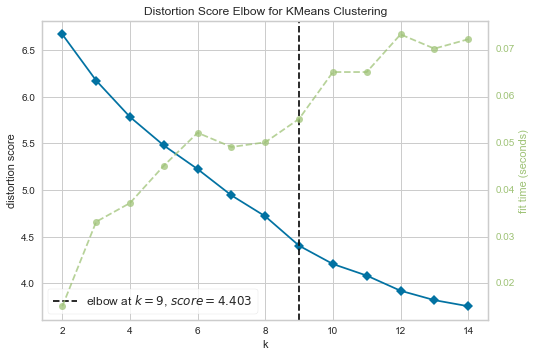

For n_clusters = 2 The average silhouette_score is : 0.8210468279184323
For n_clusters = 3 The average silhouette_score is : 0.34749284820803183
For n_clusters = 4 The average silhouette_score is : 0.1373429266201912
For n_clusters = 5 The average silhouette_score is : 0.13859718428453316
For n_clusters = 6 The average silhouette_score is : 0.14867313205978422
For n_clusters = 7 The average silhouette_score is : 0.13718219926577918
For n_clusters = 8 The average silhouette_score is : 0.13320392851477356
For n_clusters = 9 The average silhouette_score is : 0.1420527177860077
For n_clusters = 10 The average silhouette_score is : 0.1342771488194921


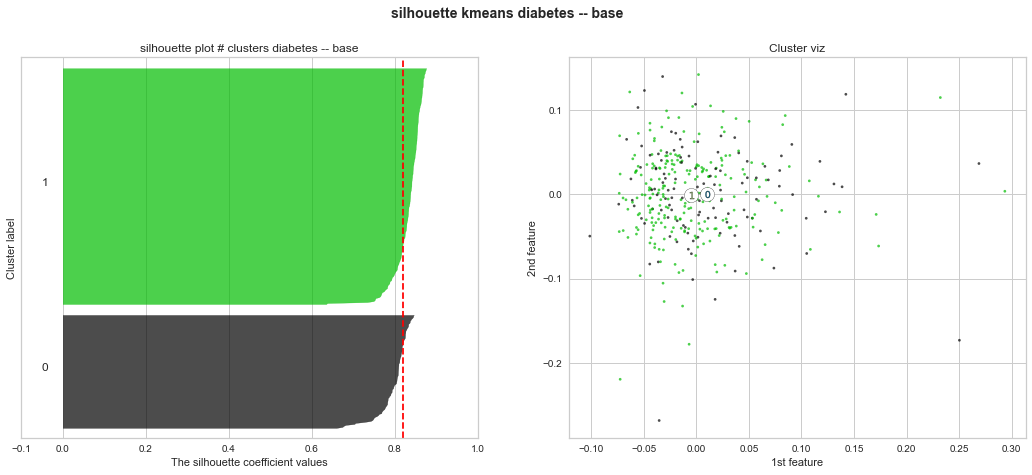

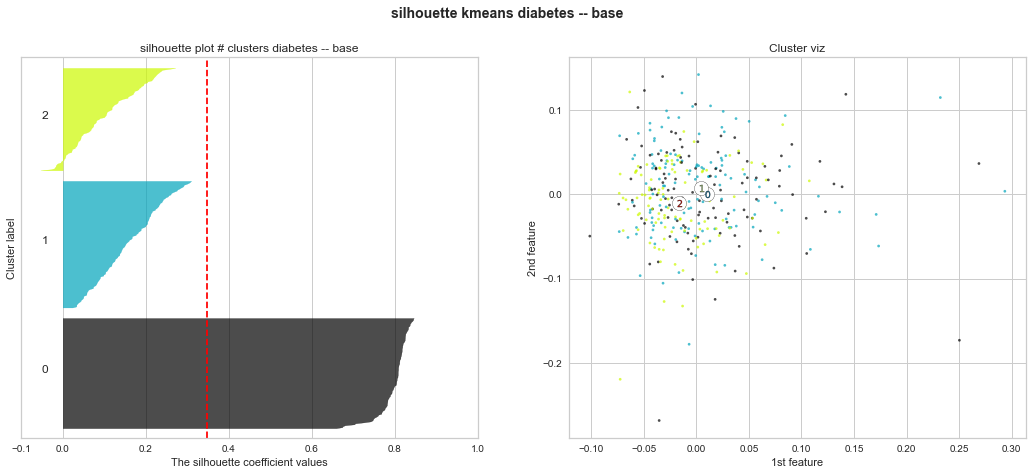

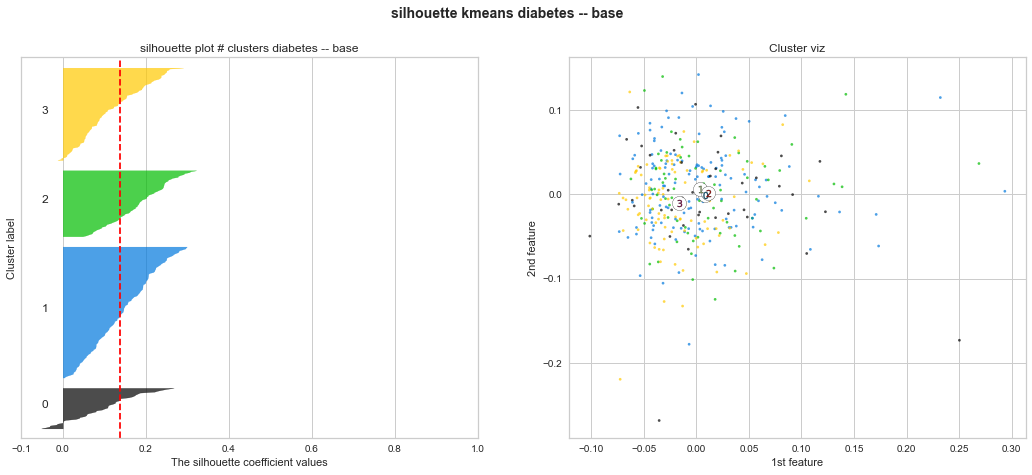

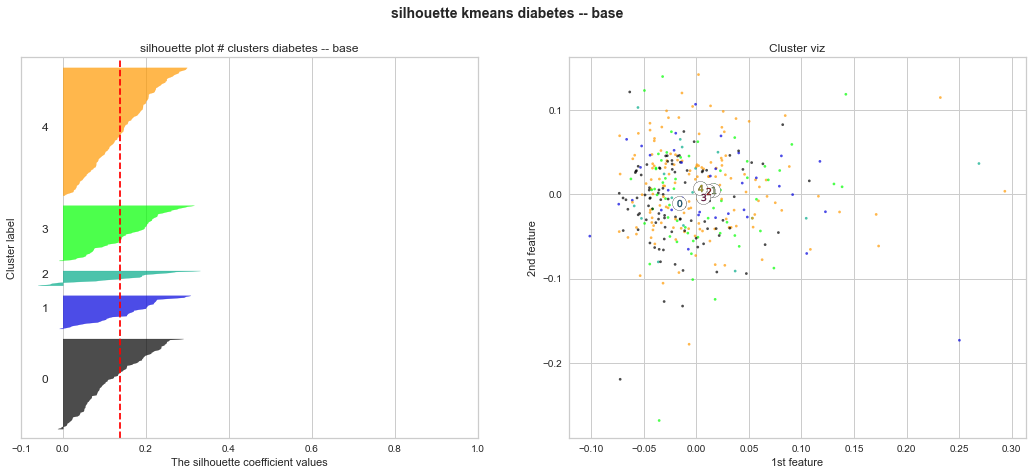

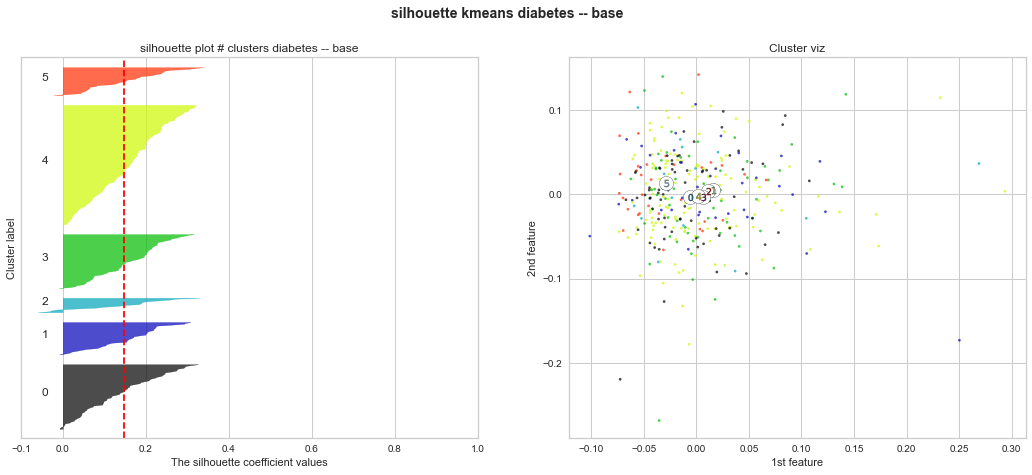

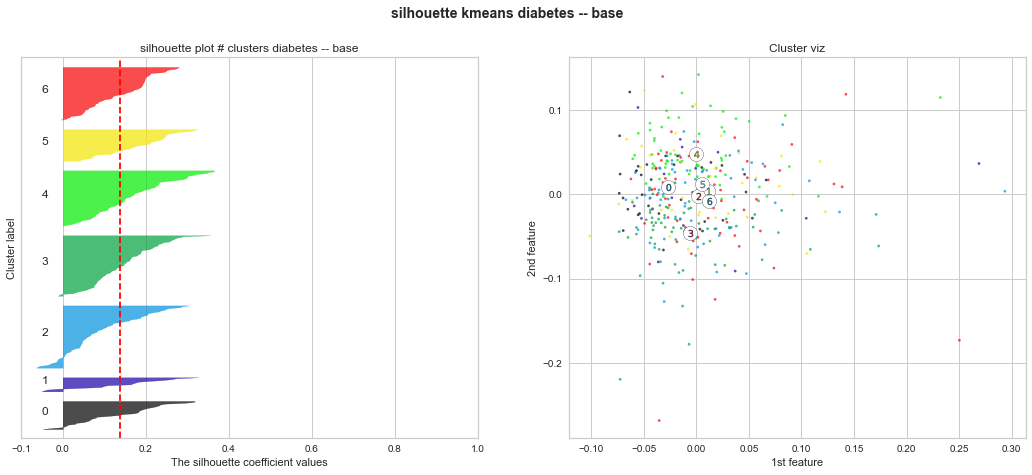

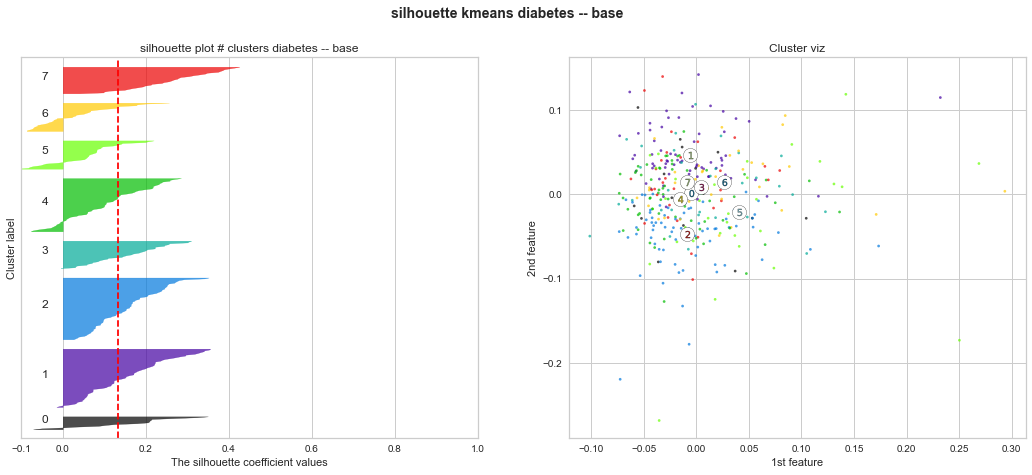

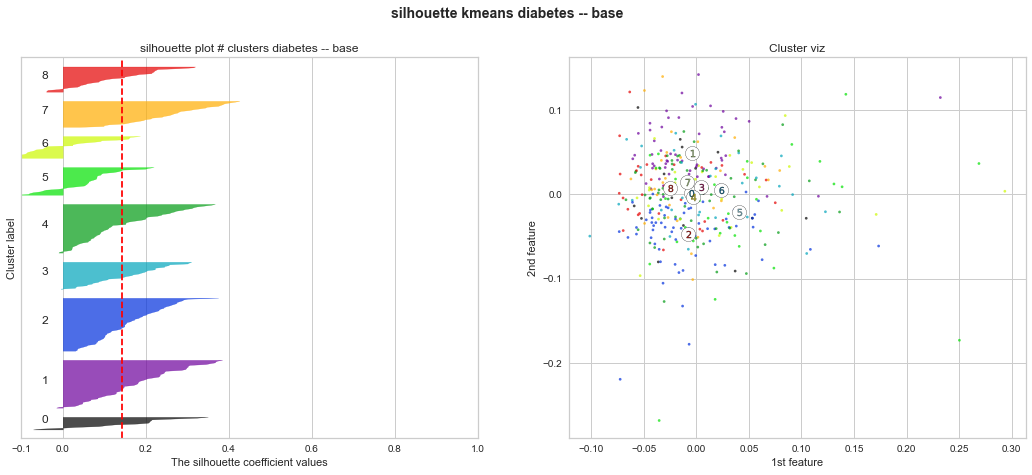

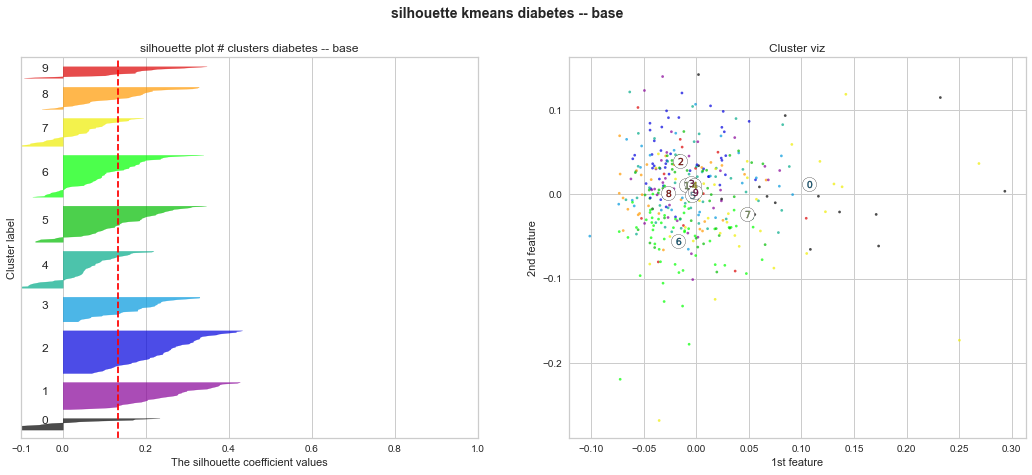

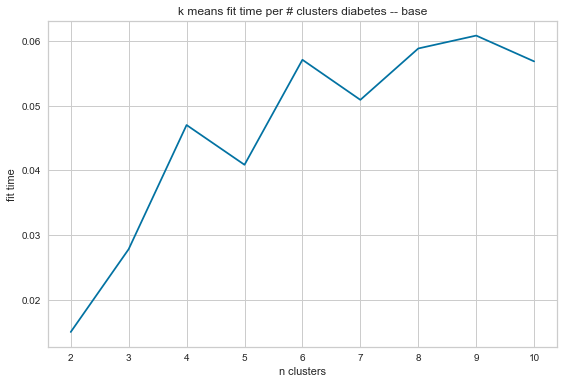

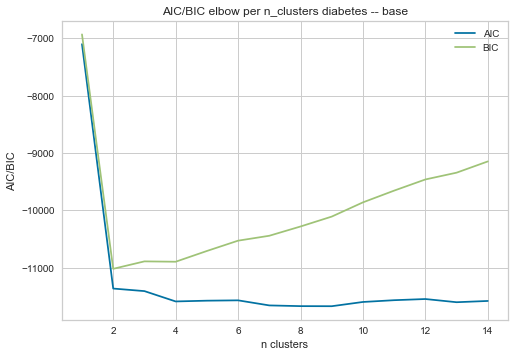

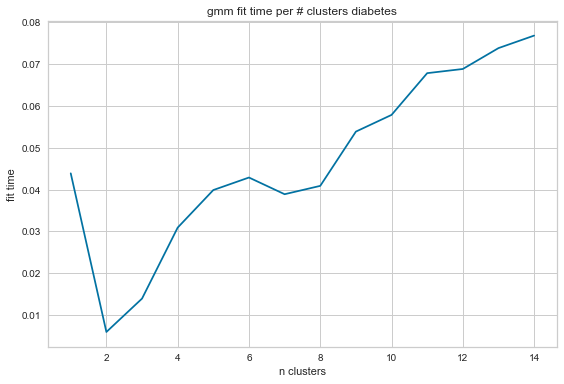

In [96]:
print(ica_X_train.shape)
k_means_elbow_viz(ica_X_train)
k_means_silhouette_iloc(ica_X_train)
GMM_elbow(ica_X_train, y_train, range_n_clusters=range(1, 15))

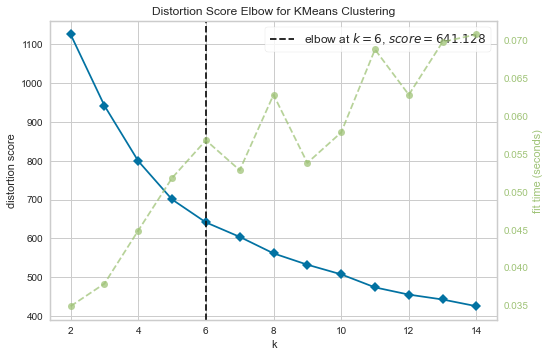

For n_clusters = 2 The average silhouette_score is : 0.2843727963613161
For n_clusters = 3 The average silhouette_score is : 0.232931873387439
For n_clusters = 4 The average silhouette_score is : 0.22390870842899516
For n_clusters = 5 The average silhouette_score is : 0.23093618698020735
For n_clusters = 6 The average silhouette_score is : 0.22848892468635806
For n_clusters = 7 The average silhouette_score is : 0.21375041735542732
For n_clusters = 8 The average silhouette_score is : 0.2022281842089643
For n_clusters = 9 The average silhouette_score is : 0.20112167361086175
For n_clusters = 10 The average silhouette_score is : 0.18607559312207775


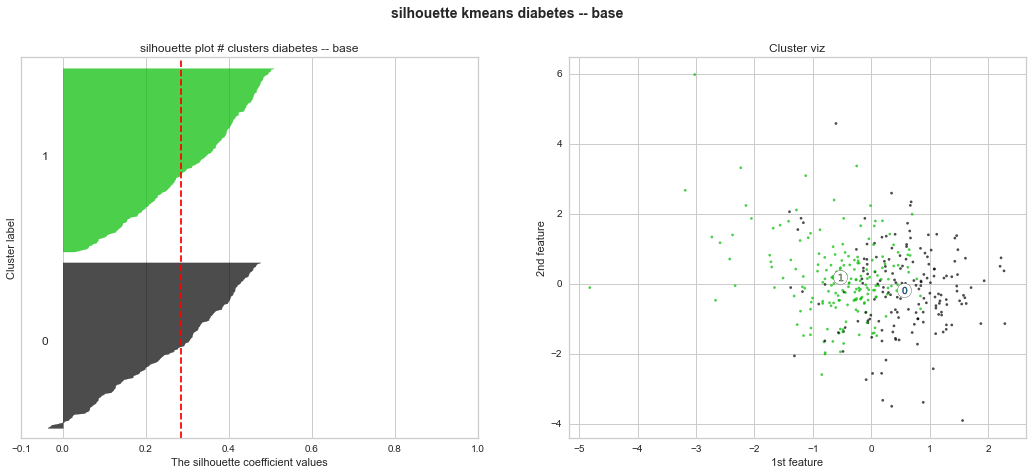

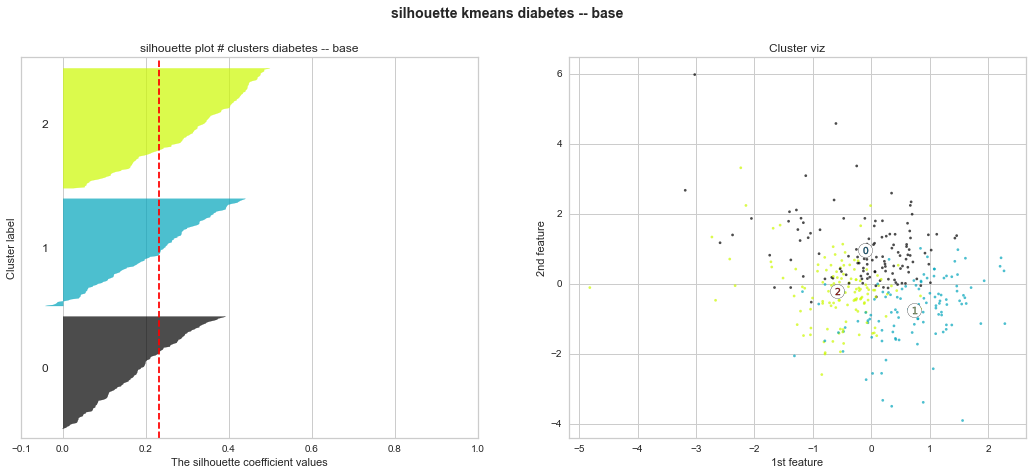

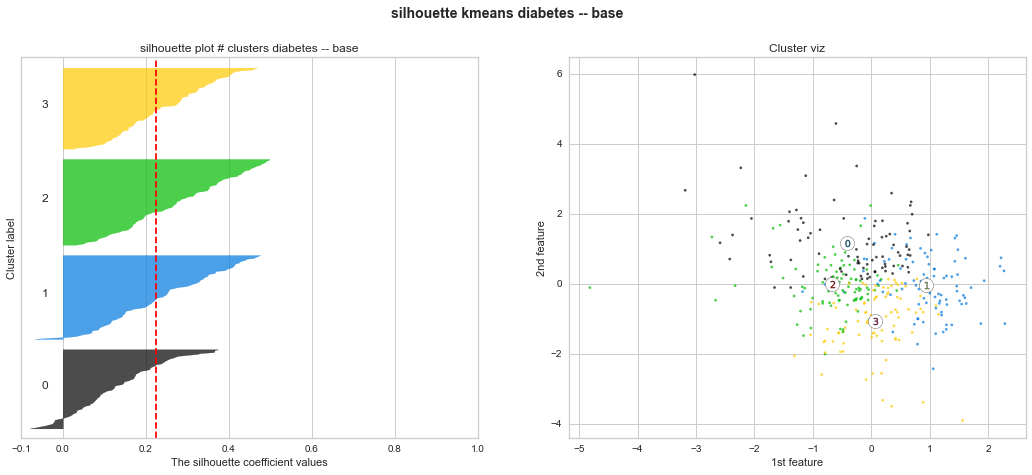

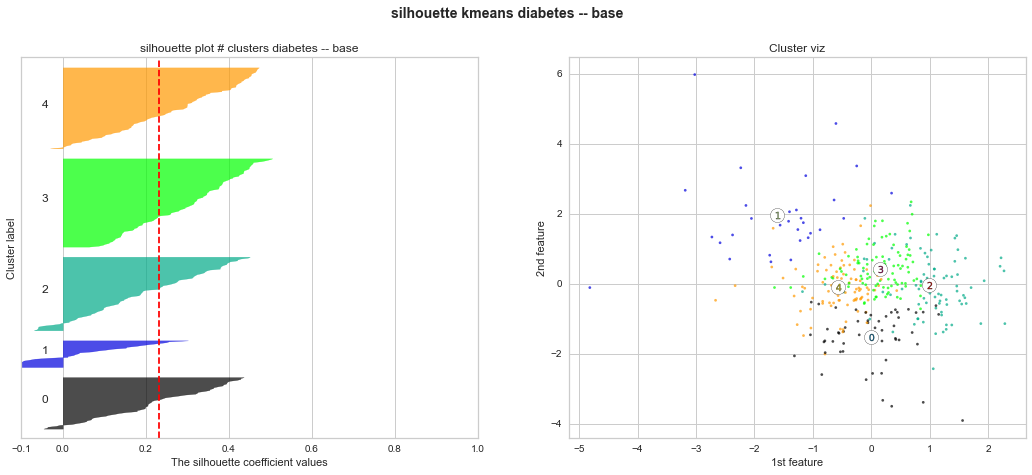

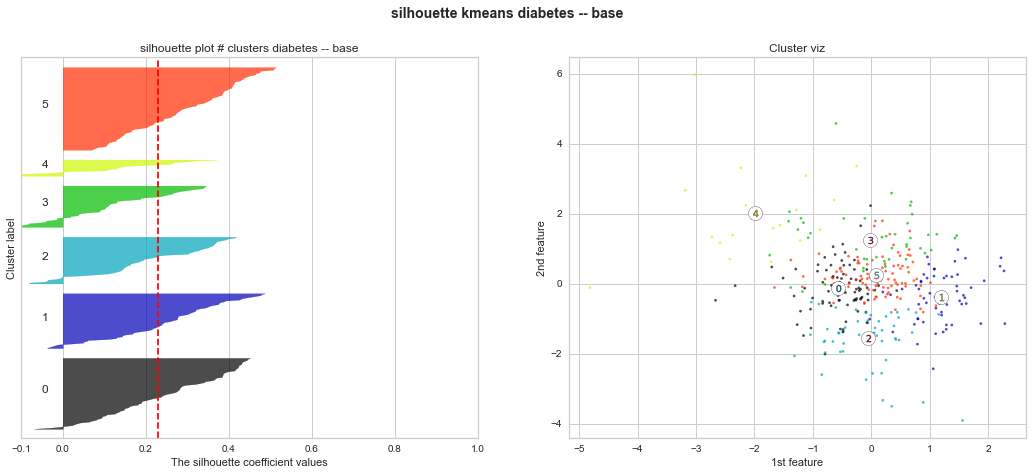

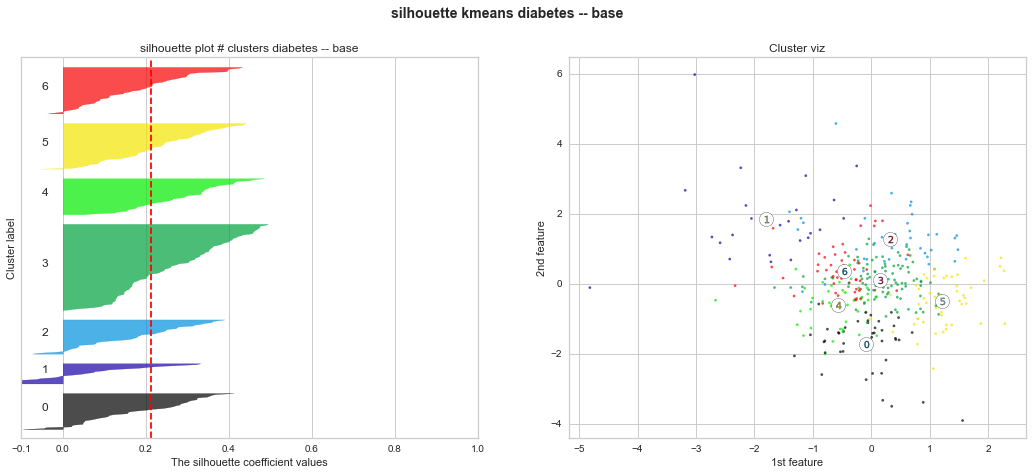

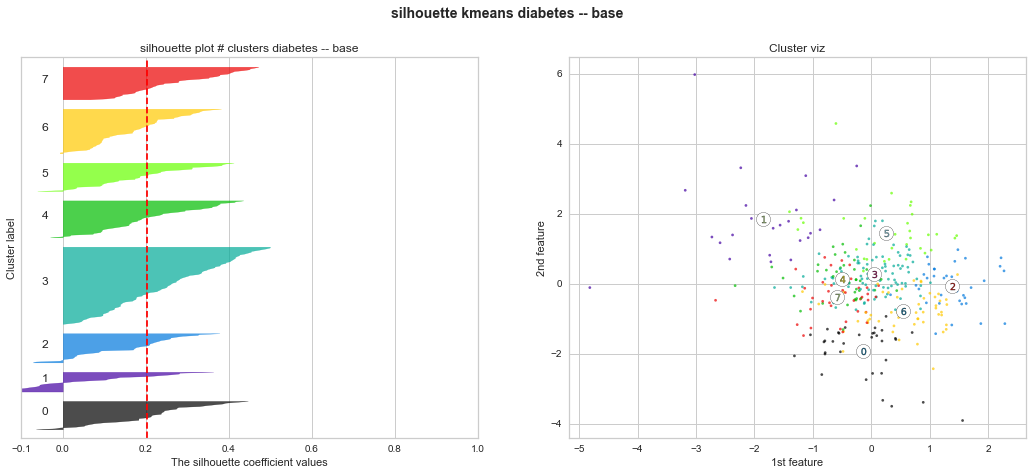

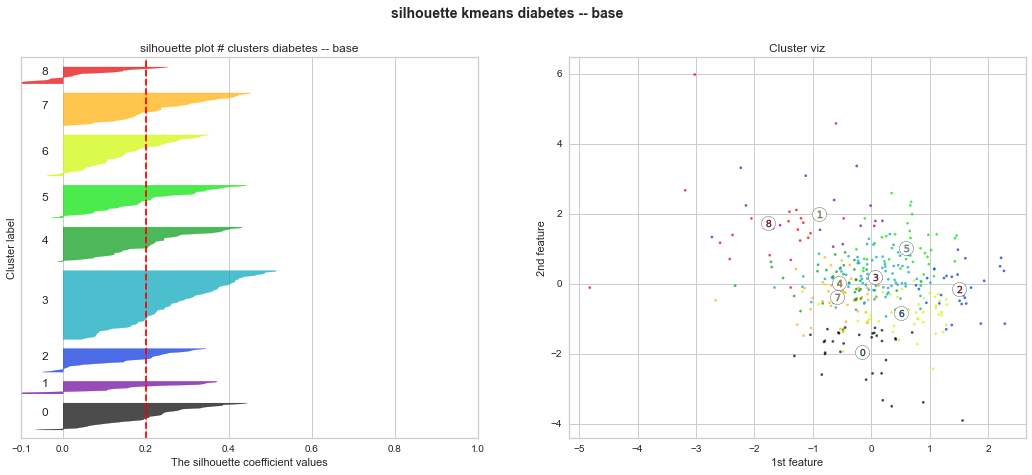

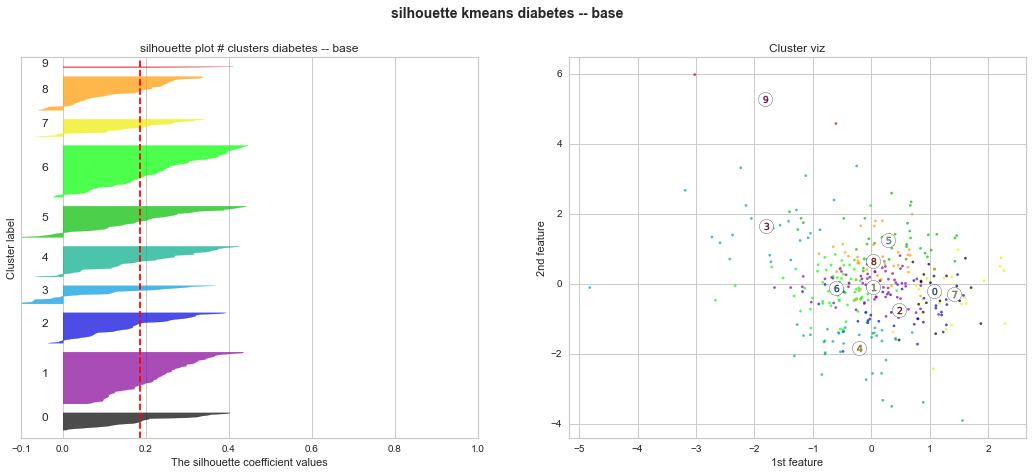

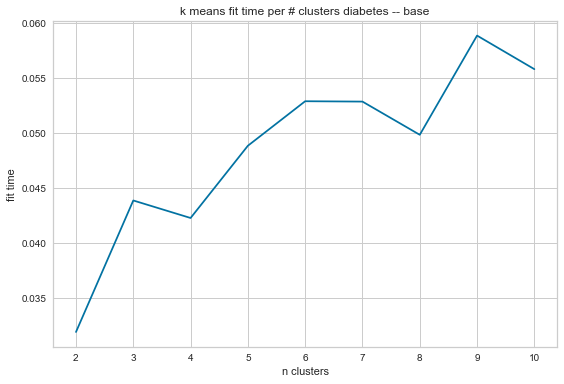

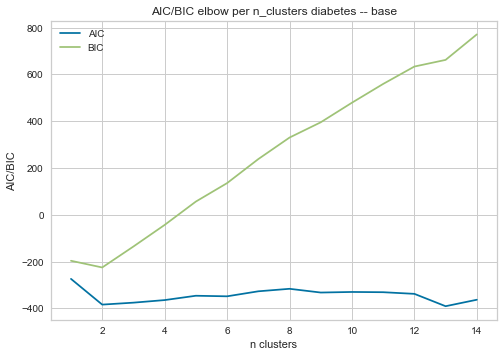

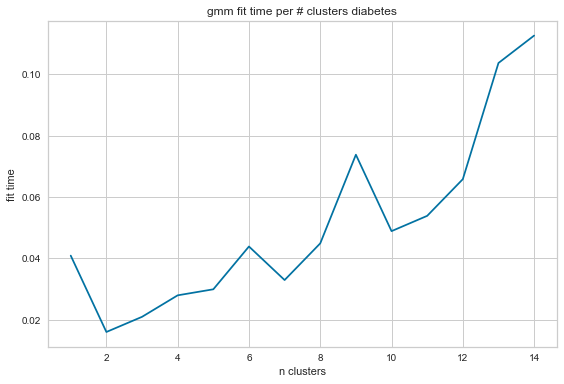

In [97]:
k_means_elbow_viz(RP_X_train)
k_means_silhouette(RP_X_train)
GMM_elbow(RP_X_train, y_train, range_n_clusters=range(1, 15))

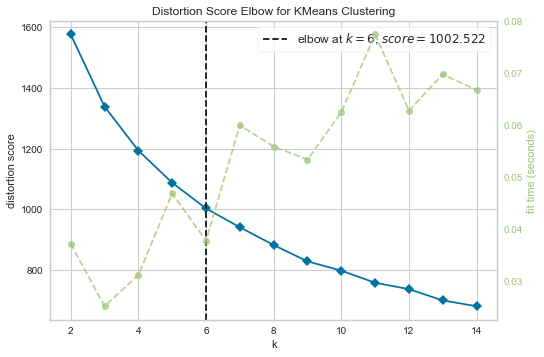

For n_clusters = 2 The average silhouette_score is : 0.23944876505000884
For n_clusters = 3 The average silhouette_score is : 0.21341380957836822
For n_clusters = 4 The average silhouette_score is : 0.22841895541531032
For n_clusters = 5 The average silhouette_score is : 0.23491574140453766
For n_clusters = 6 The average silhouette_score is : 0.18917233501750402
For n_clusters = 7 The average silhouette_score is : 0.19776073462919036
For n_clusters = 8 The average silhouette_score is : 0.17266360488397123
For n_clusters = 9 The average silhouette_score is : 0.16756525758482724
For n_clusters = 10 The average silhouette_score is : 0.174449345981689


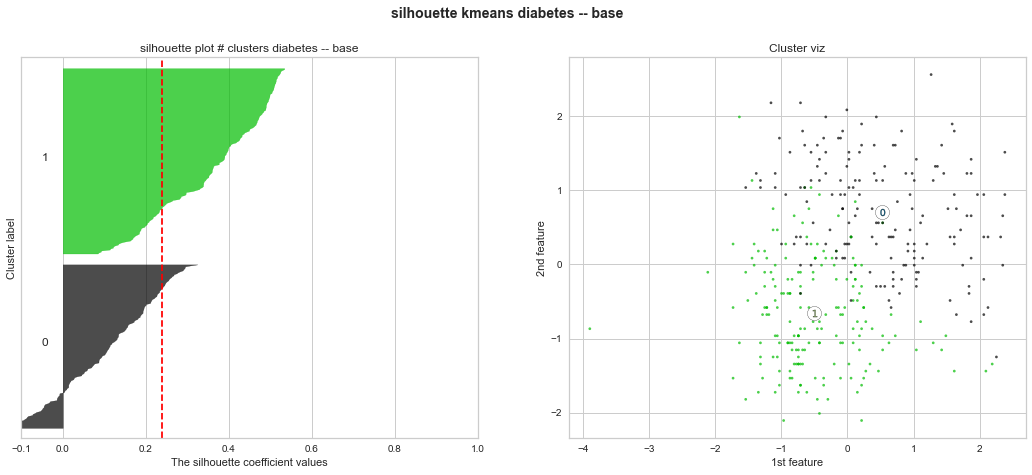

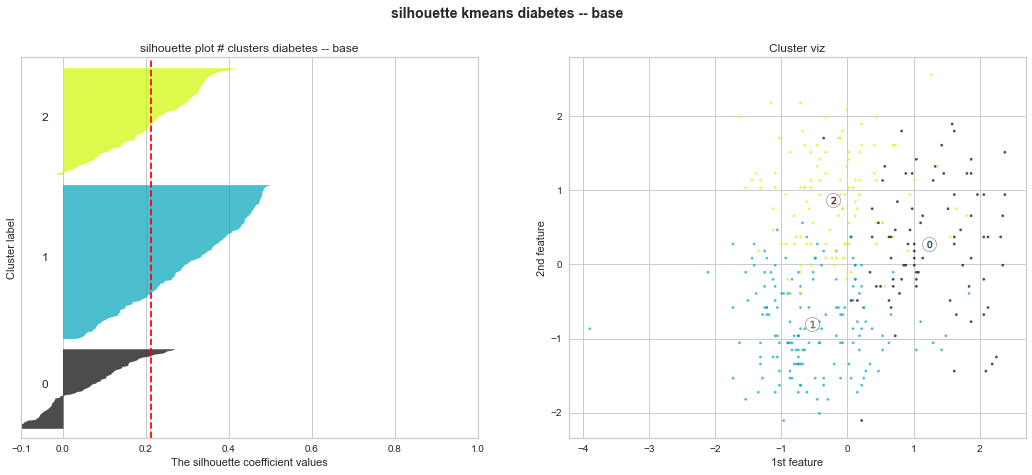

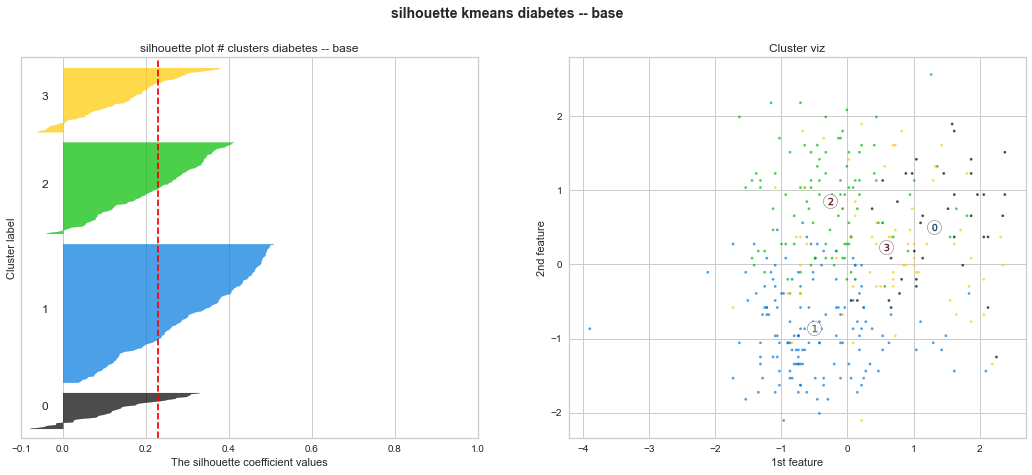

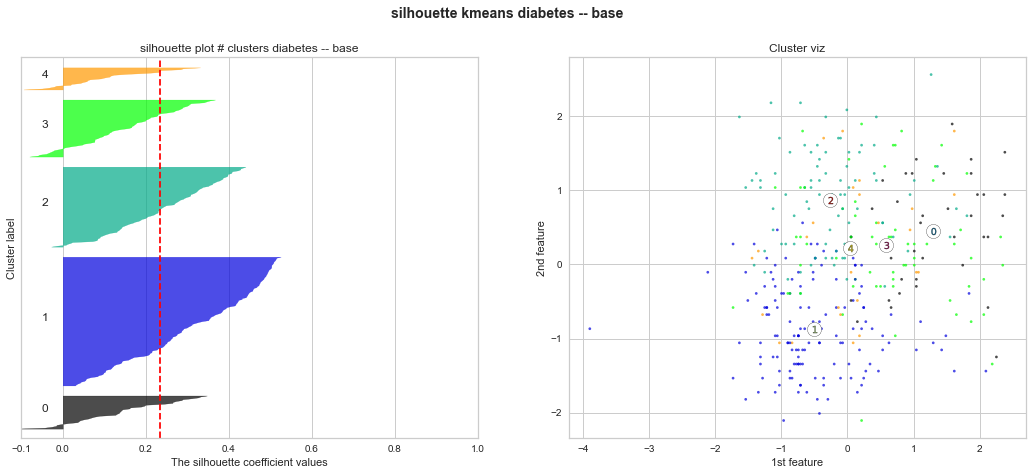

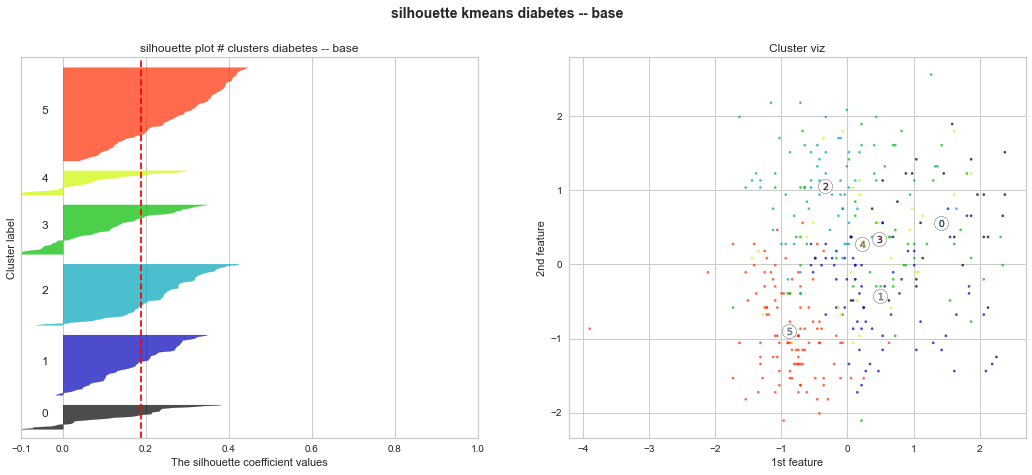

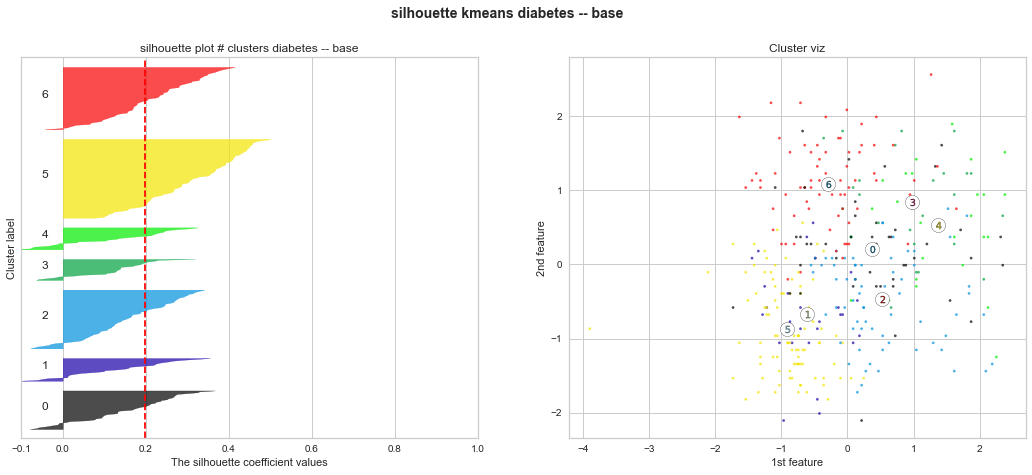

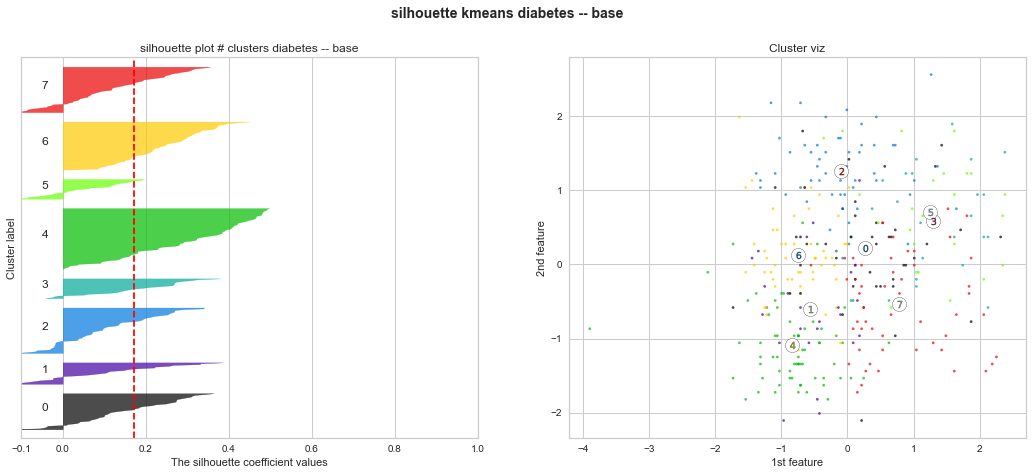

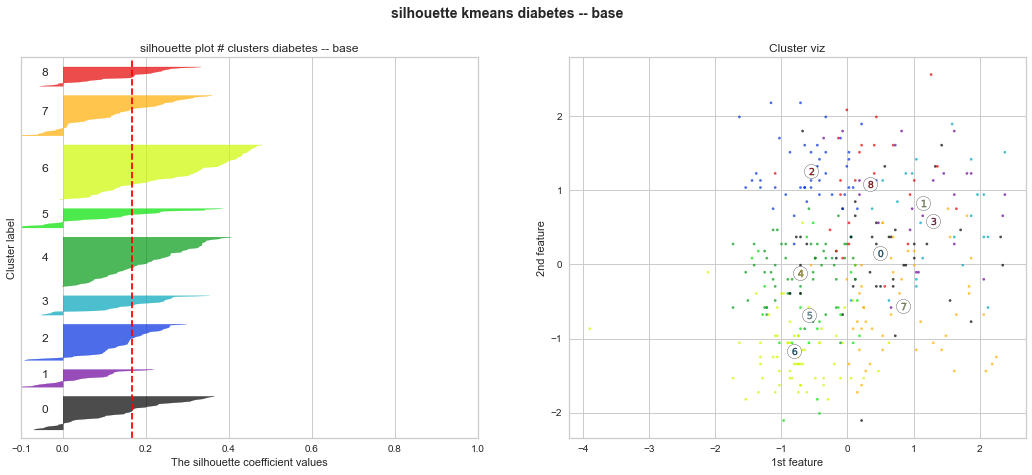

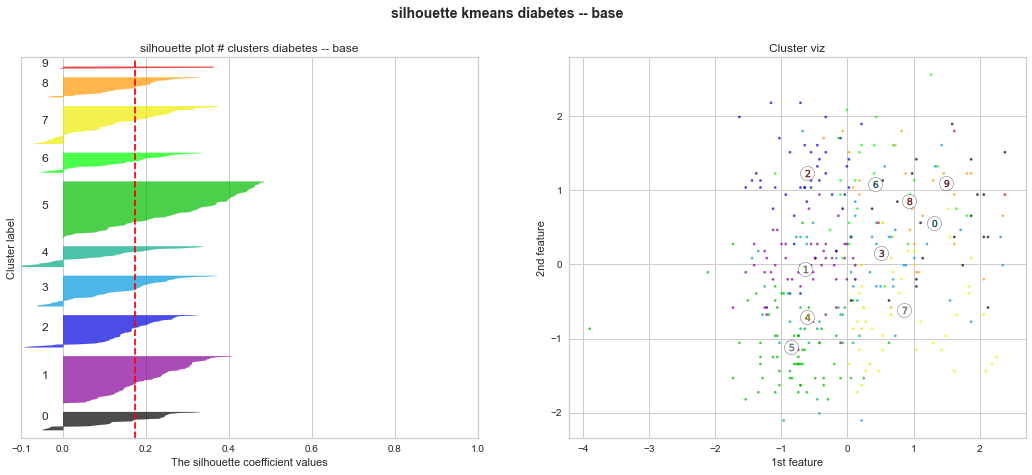

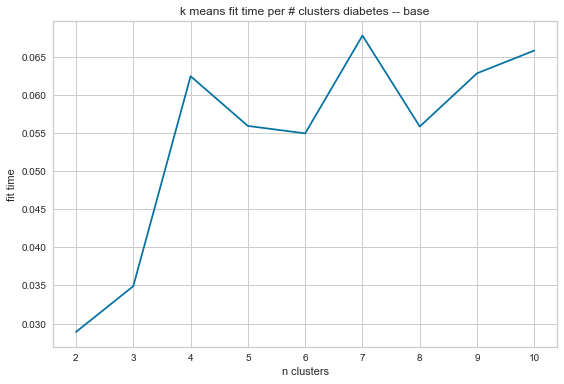

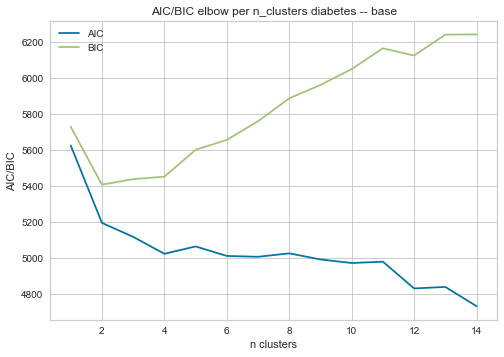

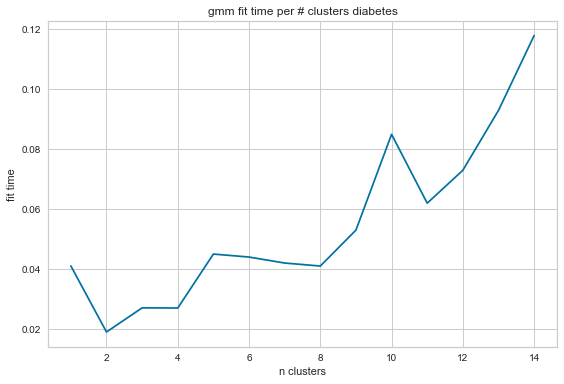

In [98]:
k_means_elbow_viz(RFC_X_train)
k_means_silhouette(RFC_X_train)
GMM_elbow(RFC_X_train, y, range_n_clusters=range(1, 15))

# Neural Network

In [99]:
print(X_train.shape)
print(pca_X_train.shape)

(354, 8)
(354, 6)


In [ ]:

run_neural_network(X_train, y_train, X_test, y_test)

In [ ]:
print(pca_X.shape)
run_neural_network(pca_X_train, y_train, pca_X_test, y_test)

In [ ]:
nearest_perfect_square(228)

In [102]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
nnet = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=13)
X_scaled = preprocessing.scale(X_train)
nnet.fit(X_scaled, y_train)  
#data_train_pred = data_nn.predict(data)
#float(sum(data_train_pred == labels))/float(len(labels))
#data_test_pred = data_nn.predict(data_test) # data_test = x_test
#float(sum(data_test_pred == labels_test))/float(len(labels_test))

c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=13,
              solver='lbfgs')

In [104]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.73452750
Iteration 2, loss = 0.60051889
Iteration 3, loss = 0.51564913
Iteration 4, loss = 0.47665863
Iteration 5, loss = 0.46519616
Iteration 6, loss = 0.46211677
Iteration 7, loss = 0.46393819
Iteration 8, loss = 0.45869607
Iteration 9, loss = 0.45371276
Iteration 10, loss = 0.44594991
Iteration 11, loss = 0.43794095
Iteration 12, loss = 0.43073981
Iteration 13, loss = 0.42616145
Iteration 14, loss = 0.42062540
Iteration 15, loss = 0.41760533
Iteration 16, loss = 0.41502233
Iteration 17, loss = 0.41258300
Iteration 18, loss = 0.41021663
Iteration 19, loss = 0.40746960
Iteration 20, loss = 0.40530908
Iteration 21, loss = 0.40245804
Iteration 22, loss = 0.40001360
Iteration 23, loss = 0.39785102
Iteration 24, loss = 0.39568442
Iteration 25, loss = 0.39362162
Iteration 26, loss = 0.39158640
Iteration 27, loss = 0.38966176
Iteration 28, loss = 0.38865517
Iteration 29, loss = 0.38615368
Iteration 30, loss = 0.38432318
Iteration 31, loss = 0.38296798
Iteration 32, los

Iteration 303, loss = 0.11171309
Iteration 304, loss = 0.11143852
Iteration 305, loss = 0.11065167
Iteration 306, loss = 0.11027836
Iteration 307, loss = 0.10837363
Iteration 308, loss = 0.10847880
Iteration 309, loss = 0.10984825
Iteration 310, loss = 0.10816175
Iteration 311, loss = 0.11067804
Iteration 312, loss = 0.10824076
Iteration 313, loss = 0.10746339
Iteration 314, loss = 0.10515500
Iteration 315, loss = 0.10400316
Iteration 316, loss = 0.10404386
Iteration 317, loss = 0.10411361
Iteration 318, loss = 0.10382381
Iteration 319, loss = 0.10111030
Iteration 320, loss = 0.10069145
Iteration 321, loss = 0.10072464
Iteration 322, loss = 0.10170102
Iteration 323, loss = 0.10091825
Iteration 324, loss = 0.09856280
Iteration 325, loss = 0.09902338
Iteration 326, loss = 0.09822177
Iteration 327, loss = 0.09947134
Iteration 328, loss = 0.09761365
Iteration 329, loss = 0.09682923
Iteration 330, loss = 0.09565701
Iteration 331, loss = 0.09479131
Iteration 332, loss = 0.09500763
Iteration 

c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=500,
              random_state=1, solver='sgd', verbose=10)

In [105]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.800000


ValueError: cannot reshape array of size 8 into shape (28,28)

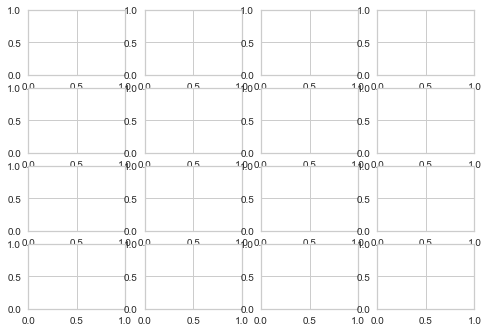

In [106]:
fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    plt.plot(loss_values)
    plt.show()

    return plt


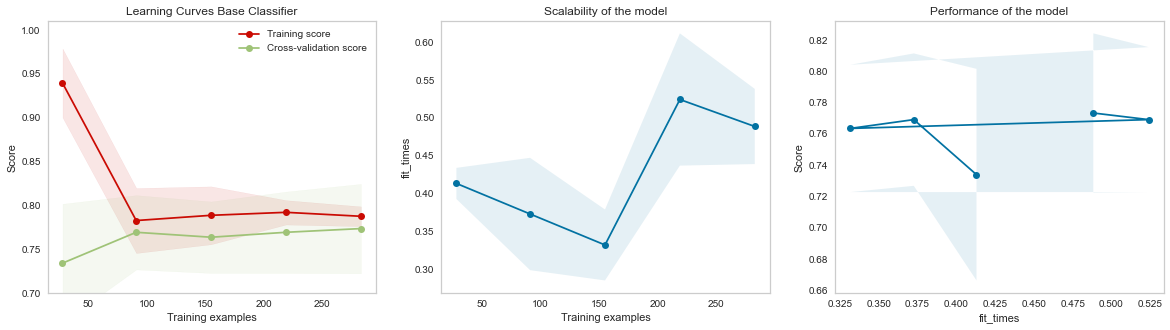

0.85
time:  0.5455656051635742


In [213]:
title = r"Learning Curves Base Classifier"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
time_start = time.time()
estimator.fit(X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(X_test, y_test))
print("time: ", time_elapsed)

(354, 6)


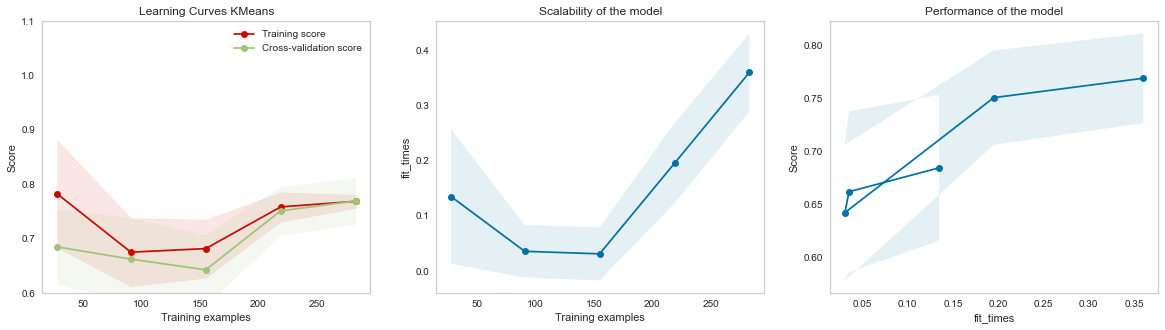

0.8
time:  0.4637281894683838


In [216]:
print(kmeans_X_train.shape)
title = r"Learning Curves KMeans"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
plot_learning_curve(estimator, title, kmeans_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()



estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
time_start = time.time()
estimator.fit(kmeans_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(kmeans_X_test, y_test))
print("time: ", time_elapsed)

(354, 6)


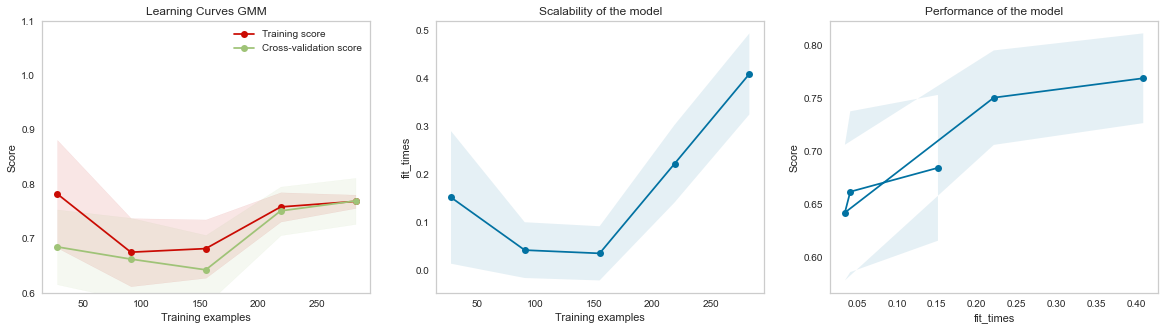

0.8
time:  0.3899238109588623


In [217]:
print(gmm_X_train.shape)
title = r"Learning Curves GMM"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
plot_learning_curve(estimator, title, gmm_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)

time_start = time.time()
estimator.fit(gmm_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(gmm_X_test, y_test))
print("time: ", time_elapsed)

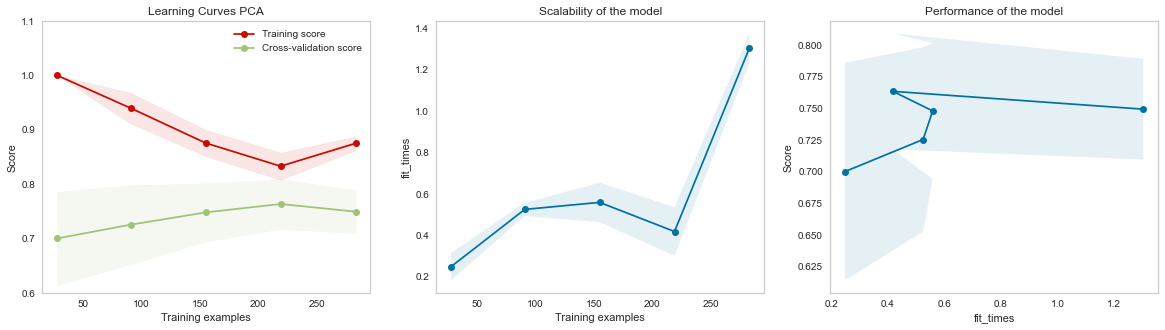

0.825
time:  1.6635491847991943


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [207]:
title = r"Learning Curves PCA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.01)
plot_learning_curve(estimator, title, pca_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.01)
time_start = time.time()
estimator.fit(pca_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(pca_X_test, y_test))
print("time: ", time_elapsed)

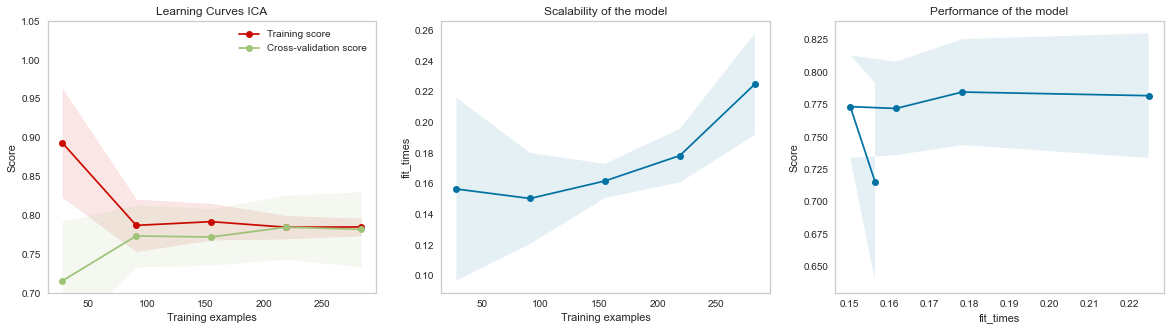

0.85
time:  0.28324222564697266


In [199]:
title = r"Learning Curves ICA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, ica_X_train, y_train, ylim=(0.7, 1.05),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(ica_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(ica_X_test, y_test))
print("time: ", time_elapsed)

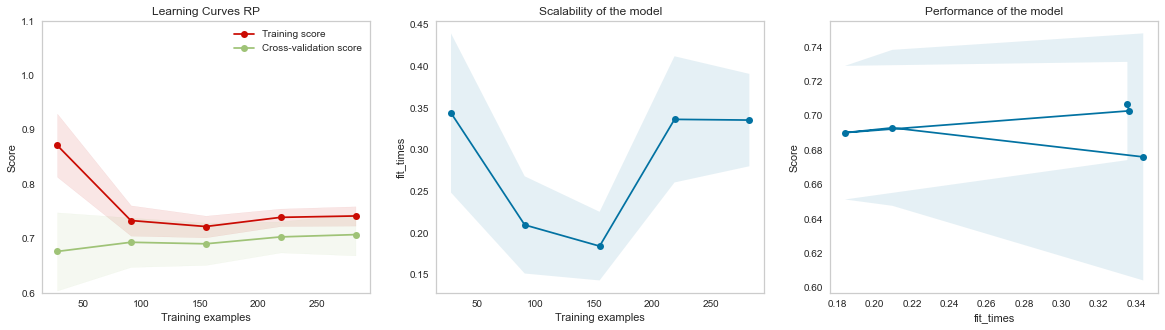

0.8
time:  0.38497018814086914


In [202]:
title = r"Learning Curves RP"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
plot_learning_curve(estimator, title, RP_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
time_start = time.time()
estimator.fit(RP_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(RP_X_test, y_test))
print("time: ", time_elapsed)

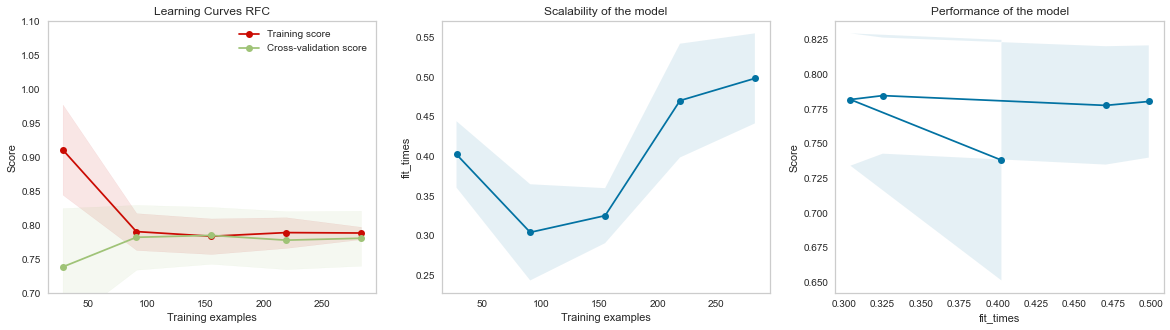

0.825
time:  0.6133594512939453


In [205]:
title = r"Learning Curves RFC"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
plot_learning_curve(estimator, title, RFC_X_train, y_train, ylim=(0.7, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.001)
time_start = time.time()
estimator.fit(RFC_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(RFC_X_test, y_test))
print("time: ", time_elapsed)